# Load Library

In [2]:
# general imports
import sys
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import multiprocessing as mp
import wandb

from sklearn.model_selection import train_test_split 

In [3]:
torch.__version__

'2.2.2'

In [4]:
# get the DGD modules (once the current version is public we can switch to the repo)
# git clone https://github.com/Center-for-Health-Data-Science/DeepGenerativeDecoder.git
# for now I added them to this repo, but the imports will stay the same
from base.dgd.nn import NB_Module
from base.dgd.DGD import DGD

# get the new stuff
from base.utils.helpers import set_seed
from base.model.decoder import Decoder
from base.data.dataset import GeneExpressionDataset
from base.engine.train import train_dgd_mirna
from tqdm import tqdm
from base.dgd.latent import RepresentationLayer


# Set seeds, device, and directory

In [5]:
# set random seeds, device and data directory
seed = 42
set_seed(seed)

num_workers = 8

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

datadir = "./data/"

cpu


# Load Data

In [6]:
# tcga_mrna_raw = pd.read_table("data/TCGA_mrna_counts_match_iso.tsv", sep='\t', index_col=[0])
tcga_mirna_raw = pd.read_table("data/TCGA_mirna_counts_match_iso.tsv", sep='\t', index_col=[0])

In [7]:
mirna_annot = pd.read_table("data/TCGA_mirna_anno_iso_match.tsv", sep='\t', index_col=[0])

In [8]:
def data_filtering(df, filter_zero=True, filter_tumor=False):
    if filter_zero:
        zero_counts = (df == 0).mean()
        selected_features = zero_counts[zero_counts < 0.99].index
        df = df[selected_features]
    if filter_tumor:
        df = df[df['sample_type'].isin(['Primary Tumor', 'Solid Tissue Normal'])]
        
    return df

tcga_mirna = data_filtering(tcga_mirna_raw)

## Data Loader

In [9]:
# shuffle the data
tcga_mirna = tcga_mirna.sample(frac=1, random_state=seed)

In [10]:
# make data split for train, validation, and test sets
train_ratio= 0.7
batch_size = 128

train_mirna, val_mirna = train_test_split(tcga_mirna, train_size=train_ratio, stratify=tcga_mirna['cancer_type'], random_state=seed) 
val_mirna, test_mirna = train_test_split(val_mirna, test_size=0.50, stratify=val_mirna['cancer_type'], random_state=seed)

# Train, val, and test data loaders
# Default scaling_type = "mean"
train_dataset = GeneExpressionDataset(train_mirna, scaling_type='mean')
validation_dataset = GeneExpressionDataset(val_mirna, scaling_type='mean')
test_dataset = GeneExpressionDataset(test_mirna, scaling_type='mean')

train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True,
                                           num_workers=num_workers)
validation_loader = torch.utils.data.DataLoader(validation_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=False,
                                                num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False,
                                          num_workers=num_workers)

data_loader = train_loader, validation_loader, test_loader

In [11]:
# make data split for train and validation sets
mirna_out_dim = tcga_mirna.shape[1]-4

In [12]:
print(train_mirna.shape)
print(val_mirna.shape)
print(test_mirna.shape)
print(mirna_out_dim)

(7473, 2028)
(1601, 2028)
(1602, 2028)
2024


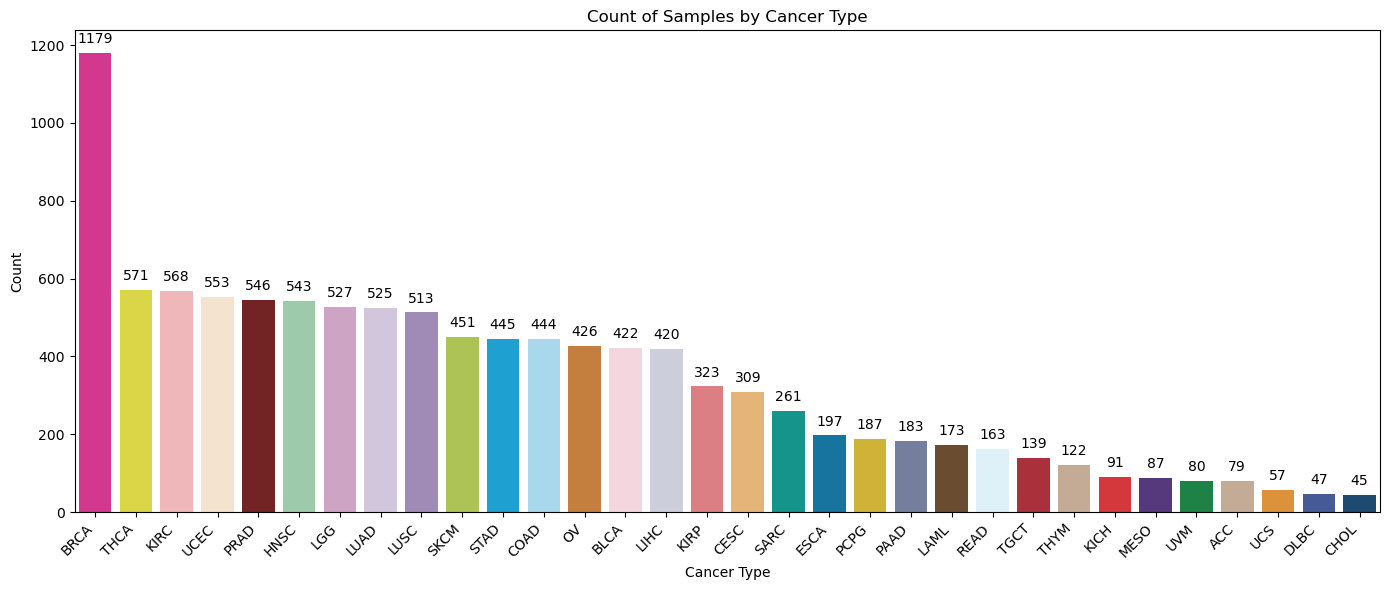

In [13]:
color_mapping = dict(zip(tcga_mirna['cancer_type'], tcga_mirna['color']))

primary_site_counts = tcga_mirna['cancer_type'].value_counts().reset_index()
primary_site_counts.columns = ['cancer_type', 'count']

# Create a bar plot
plt.figure(figsize=(14, 6))
barplot = sns.barplot(x='cancer_type', hue='cancer_type', y='count', data=primary_site_counts, palette=color_mapping)
plt.xlabel('Cancer Type')
plt.ylabel('Count')
plt.title('Count of Samples by Cancer Type')
plt.xticks(rotation=45, ha='right')  # Rotate the x labels to show them more clearly

# Annotate each bar with the count
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'),  # Format the count as a string with no decimal places
                     (p.get_x() + p.get_width() / 2., p.get_height()),  # Position the text at the center of the bar
                     ha='center', va='center',  # Center the text horizontally and vertically
                     xytext=(0, 10),  # Offset the text by 10 points vertically
                     textcoords='offset points')  # Use offset points for the text coordinates

plt.tight_layout()  # Adjust the layout to fit the x labels
plt.show()

# Model Setup

In [13]:
# This one is used for n GMM mixture component 
n_tissues = len(np.unique(train_dataset.label))

# Hyperparameters for Decoder
latent_dim = 20 # For the representation layer 
hidden_dims = [128, 128, 128] # Decoder common hidden dimension
reduction_type = "sum" # Output loss reduction, you can choose "mean". This is how you want calculate the total loss. 
activation = "relu" # ["relu", "leaky_relu"]
r_init = 2

# Hyperparameters for GMM
gmm_mean = 5.0 # usually between 2 and 10
sd_mean = 0.2 # default 0.2

In [14]:
# Output Module Setup
mirna_out_fc = nn.Sequential(
    nn.Linear(hidden_dims[-1], mirna_out_dim)
    )
output_mirna_layer = NB_Module(mirna_out_fc, mirna_out_dim, r_init=r_init, scaling_type="mean")
output_mirna_layer.n_features = mirna_out_dim

# Set up the decoder
decoder = Decoder(latent_dim, hidden_dims, output_module=output_mirna_layer).to(device)

# Setup GMM init
gmm_mean_scale = gmm_mean # usually between 2 and 10
sd_mean_init = sd_mean * gmm_mean_scale / n_tissues # empirically good for single-cell data at dimensionality 20

In [15]:
# Init a DGD model
dgd = DGD(
        decoder=decoder,
        n_mix=n_tissues,
        rep_dim=latent_dim,
        gmm_spec={"mean_init": (gmm_mean_scale, 5.0), "sd_init": (sd_mean_init, 1.0), "weight_alpha": 1}
)

In [16]:
dgd

DGD(
  (decoder): Decoder(
    (main): ModuleList(
      (0): Linear(in_features=20, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): ReLU()
    )
    (out_module): NB_Module(
      (fc): Sequential(
        (0): Linear(in_features=128, out_features=2024, bias=True)
      )
    )
  )
  (gmm): GaussianMixture()
)

## Training loop

In [33]:
sample_mirna = ['MIMAT0000421', 'MIMAT0000422', 'MIMAT0000435', 'MIMAT0000728']
sample_index = [tcga_mirna.columns.get_loc(a) for a in sample_mirna]
sample_index

[1371, 1304, 34, 359]

In [17]:
# Training hyperparameters
learning_rates = {'dec':1e-4,'rep':0.01,'gmm':0.01}
weight_decay = 1e-5
betas = (0.5, 0.7)

nepochs = 801
pr = 5 # how often to print epoch
plot = 400 # how often to print plot
subset = 1371
sample_index = [1382, 1310, 34, 1371]

In [18]:
print("Hyperparameters:")
print(f"Latent dimension: {latent_dim}")
print(f"Learning rates: {learning_rates}")
print(f"Weight decay: {weight_decay}")
print(f"betas: {betas}")
print(f"Number of epochs: {nepochs}")
print(f"Hidden dimensions: {hidden_dims}")
print(f"Batch size: {batch_size}")
print(f"Reduction type: {reduction_type}")

Hyperparameters:
Latent dimension: 20
Learning rates: {'dec': 0.0001, 'rep': 0.01, 'gmm': 0.01}
Weight decay: 1e-05
betas: (0.5, 0.7)
Number of epochs: 801
Hidden dimensions: [128, 128, 128]
Batch size: 128
Reduction type: sum


# Training

  0%|                                                                                                                                     | 0/801 [00:00<?, ?it/s]

0 train_recon: 14.5366817578857 train_gmm: 8.764496879521486 train_mse: 818170880.0 train_mae: 6193.81201171875 train_r2: -0.012824535369873047 train_spearman: 0.08855950832366943 train_pearson: 0.02929571457207203 train_msle: 43.99699020385742
0 test_recon: 14.437067842047831 test_gmm: 4.564637000556293 test_mse: 463030656.0 test_mae: 5016.2548828125 test_r2: -0.010067582130432129 test_spearman: 0.06175883486866951 test_pearson: 0.019333884119987488 test_msle: 43.847557067871094


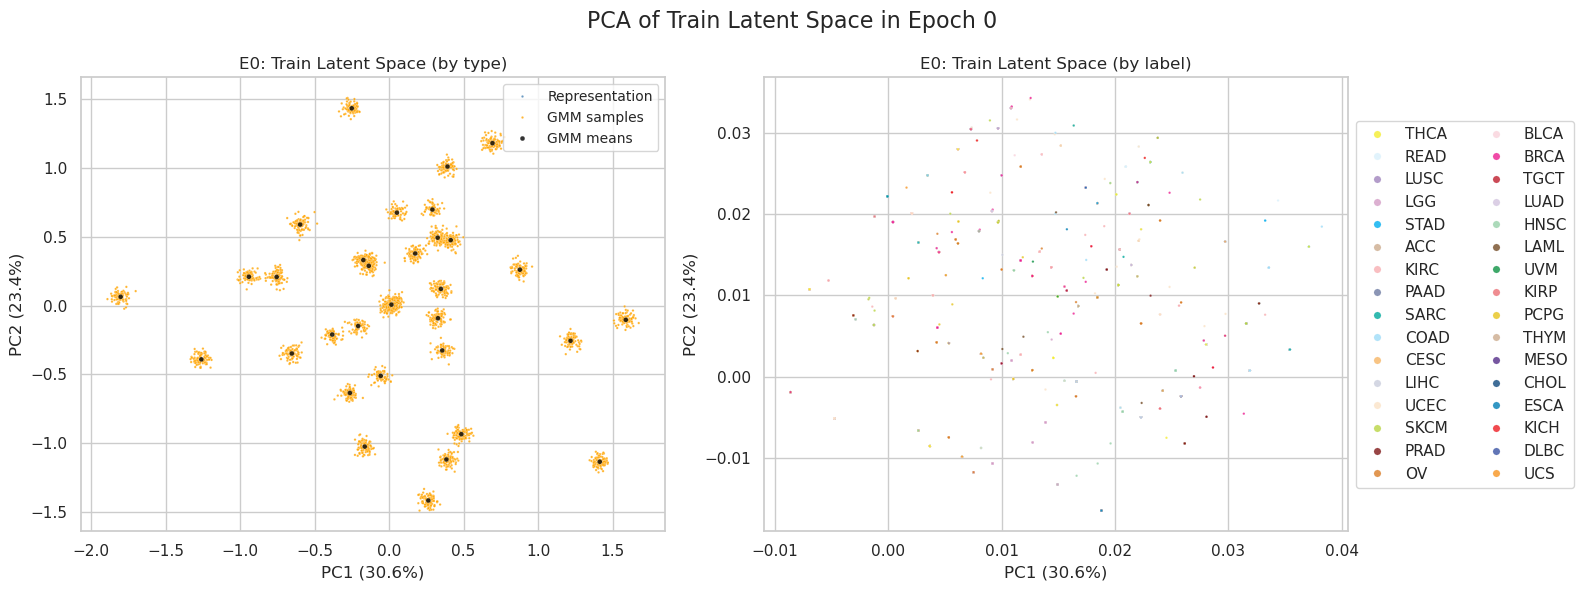

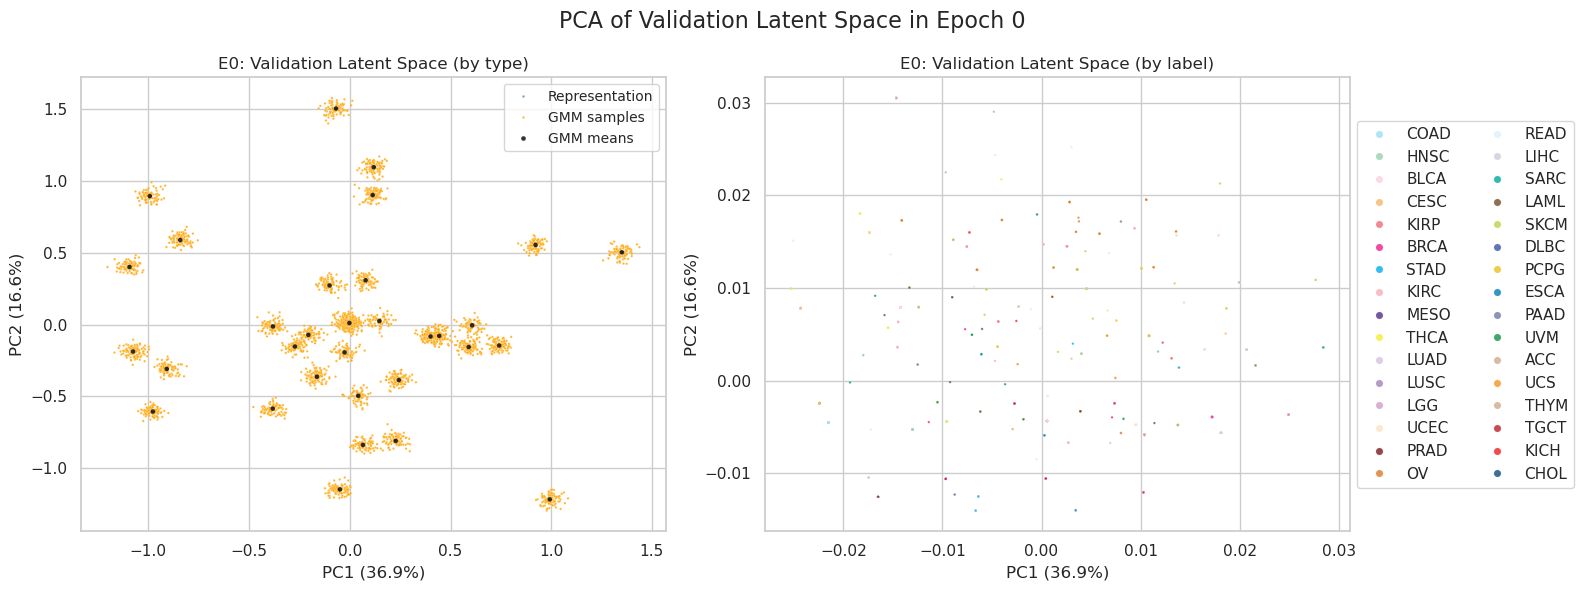

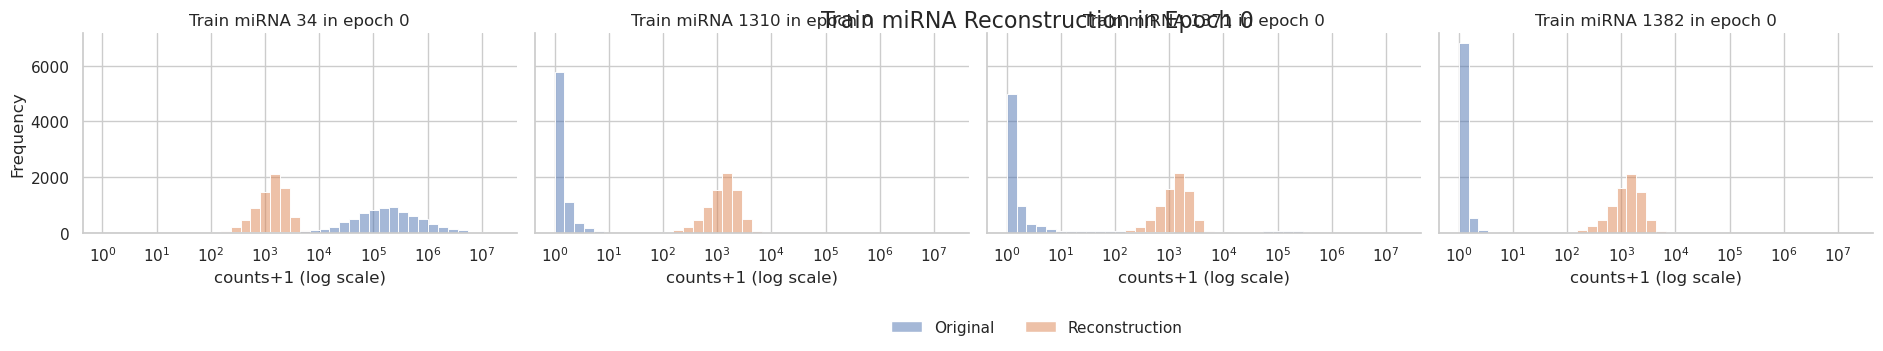

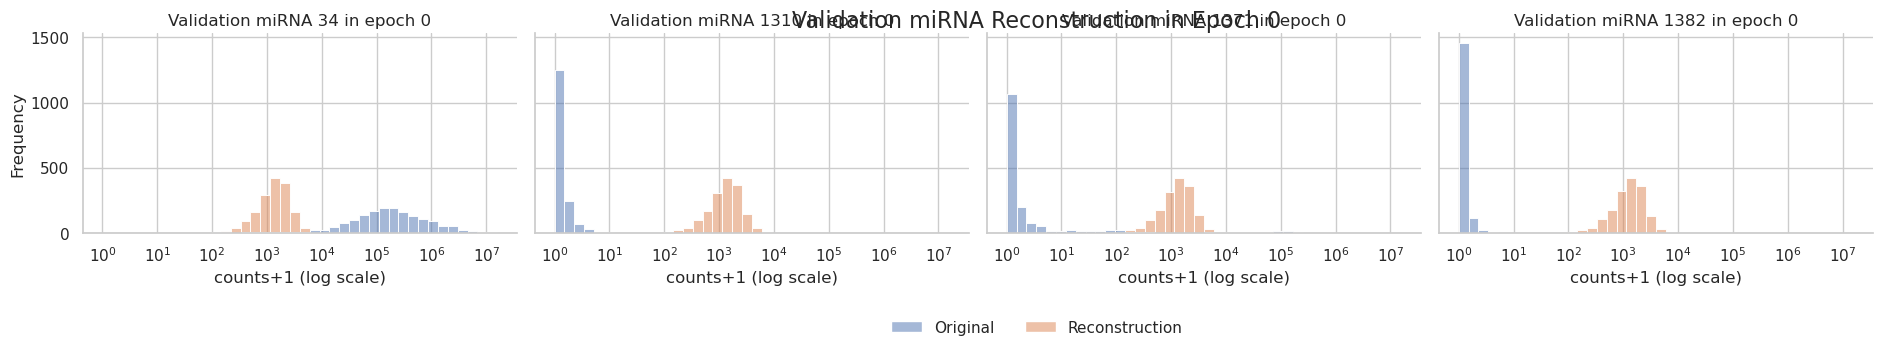

  1%|▉                                                                                                                            | 6/801 [00:19<27:00,  2.04s/it]

5 train_recon: 10.797356001202484 train_gmm: 2.142847527466065 train_mse: 810435264.0 train_mae: 8139.3671875 train_r2: -0.003248453140258789 train_spearman: 0.0885976031422615 train_pearson: 0.02946580946445465 train_msle: 55.57292556762695
5 test_recon: 9.890119703470903 test_gmm: 2.143259118751464 test_mse: 461744576.0 test_mae: 7005.14697265625 test_r2: -0.007262110710144043 test_spearman: 0.06206095963716507 test_pearson: 0.019825495779514313 test_msle: 55.5587158203125


  1%|█▋                                                                                                                          | 11/801 [00:26<19:32,  1.48s/it]

10 train_recon: 2.6594634975271982 train_gmm: 2.143529022188211 train_mse: 818074624.0 train_mae: 10370.091796875 train_r2: -0.012705326080322266 train_spearman: 0.0745815858244896 train_pearson: 0.02711409330368042 train_msle: 62.898399353027344
10 test_recon: 2.5606316198898664 test_gmm: 2.1449814386028265 test_mse: 477769056.0 test_mae: 9226.2666015625 test_r2: -0.04221832752227783 test_spearman: 0.0489758737385273 test_pearson: 0.012387970462441444 test_msle: 62.72914505004883


  2%|██▍                                                                                                                         | 16/801 [00:33<18:21,  1.40s/it]

15 train_recon: 2.4350684264240594 train_gmm: 2.146670726202872 train_mse: 814775168.0 train_mae: 9359.4677734375 train_r2: -0.008620858192443848 train_spearman: 0.06845445930957794 train_pearson: 0.017997317016124725 train_msle: 59.808441162109375
15 test_recon: 2.4247994243963134 test_gmm: 2.1474809292776 test_mse: 470311392.0 test_mae: 8231.9716796875 test_r2: -0.025950074195861816 test_spearman: 0.04570738971233368 test_pearson: 0.005451040808111429 test_msle: 59.74800109863281


  3%|███▎                                                                                                                        | 21/801 [00:40<17:51,  1.37s/it]

20 train_recon: 2.404890815722834 train_gmm: 2.14634992777384 train_mse: 814495552.0 train_mae: 9324.9912109375 train_r2: -0.00827479362487793 train_spearman: 0.06752471625804901 train_pearson: 0.018941357731819153 train_msle: 59.70137405395508
20 test_recon: 2.3978706567412167 test_gmm: 2.1467408598995745 test_mse: 469975648.0 test_mae: 8196.61328125 test_r2: -0.025217652320861816 test_spearman: 0.044716157019138336 test_pearson: 0.006535593885928392 test_msle: 59.63005828857422


  3%|████                                                                                                                        | 26/801 [00:47<17:47,  1.38s/it]

25 train_recon: 2.387396234233094 train_gmm: 2.14611561582635 train_mse: 814513216.0 train_mae: 9362.1201171875 train_r2: -0.008296608924865723 train_spearman: 0.06859734654426575 train_pearson: 0.019444618374109268 train_msle: 59.83174133300781
25 test_recon: 2.3804822686784197 test_gmm: 2.1462667223366254 test_mse: 470152576.0 test_mae: 8234.7578125 test_r2: -0.025603652000427246 test_spearman: 0.0459517203271389 test_pearson: 0.0070122480392456055 test_msle: 59.76113510131836


  4%|████▊                                                                                                                       | 31/801 [00:54<17:36,  1.37s/it]

30 train_recon: 2.36988572646111 train_gmm: 2.146176486000644 train_mse: 814190400.0 train_mae: 9337.44140625 train_r2: -0.007897019386291504 train_spearman: 0.07045495510101318 train_pearson: 0.020147064700722694 train_msle: 59.778892517089844
30 test_recon: 2.3627500212935098 test_gmm: 2.1462933932893504 test_mse: 469778272.0 test_mae: 8202.1865234375 test_r2: -0.024787068367004395 test_spearman: 0.04583602771162987 test_pearson: 0.007302078418433666 test_msle: 59.681392669677734


  4%|█████▌                                                                                                                      | 36/801 [01:01<17:36,  1.38s/it]

35 train_recon: 2.3291000733817633 train_gmm: 2.14682302741693 train_mse: 812537088.0 train_mae: 9167.3671875 train_r2: -0.005850315093994141 train_spearman: 0.079640693962574 train_pearson: 0.02427256479859352 train_msle: 59.329280853271484
35 test_recon: 2.316150216761757 test_gmm: 2.1469560726816246 test_mse: 467409728.0 test_mae: 8034.7353515625 test_r2: -0.019620299339294434 test_spearman: 0.053807251155376434 test_pearson: 0.013252098113298416 test_msle: 59.25827407836914


  5%|██████▎                                                                                                                     | 41/801 [01:08<17:32,  1.38s/it]

40 train_recon: 2.243166706550036 train_gmm: 2.149094494084956 train_mse: 811969344.0 train_mae: 9041.1552734375 train_r2: -0.005147576332092285 train_spearman: 0.1000790223479271 train_pearson: 0.02525527961552143 train_msle: 58.9271354675293
40 test_recon: 2.227798111836599 test_gmm: 2.1495625597770927 test_mse: 464808640.0 test_mae: 7887.69970703125 test_r2: -0.013946175575256348 test_spearman: 0.07240045070648193 test_pearson: 0.027446743100881577 test_msle: 58.792724609375


  6%|███████                                                                                                                     | 46/801 [01:15<17:12,  1.37s/it]

45 train_recon: 2.201309162094211 train_gmm: 2.1510542804356096 train_mse: 815604160.0 train_mae: 9400.4970703125 train_r2: -0.009647130966186523 train_spearman: 0.1013680249452591 train_pearson: 0.018036697059869766 train_msle: 59.8036003112793
45 test_recon: 2.191316774826381 test_gmm: 2.1513176121613444 test_mse: 468660928.0 test_mae: 8241.79296875 test_r2: -0.02234971523284912 test_spearman: 0.07363610714673996 test_pearson: 0.024006295949220657 test_msle: 59.647186279296875


  6%|███████▉                                                                                                                    | 51/801 [01:21<17:13,  1.38s/it]

50 train_recon: 2.1842297166042814 train_gmm: 2.1512507625106636 train_mse: 815815104.0 train_mae: 9282.4443359375 train_r2: -0.009908318519592285 train_spearman: 0.10015448927879333 train_pearson: 0.017551368102431297 train_msle: 59.301456451416016
50 test_recon: 2.175380347602659 test_gmm: 2.1513148977933714 test_mse: 468916512.0 test_mae: 8141.7998046875 test_r2: -0.022907257080078125 test_spearman: 0.07102043926715851 test_pearson: 0.020744964480400085 test_msle: 59.22861862182617


  7%|████████▋                                                                                                                   | 56/801 [01:28<17:13,  1.39s/it]

55 train_recon: 2.172135675751546 train_gmm: 2.1510451459891025 train_mse: 814629888.0 train_mae: 9140.080078125 train_r2: -0.00844109058380127 train_spearman: 0.09947867691516876 train_pearson: 0.02249140478670597 train_msle: 58.79249954223633
55 test_recon: 2.1633880897993594 test_gmm: 2.1510457483847985 test_mse: 467558432.0 test_mae: 7990.1357421875 test_r2: -0.01994466781616211 test_spearman: 0.06883955746889114 test_pearson: 0.02490193024277687 test_msle: 58.70262145996094


  8%|█████████▍                                                                                                                  | 61/801 [01:35<17:12,  1.40s/it]

60 train_recon: 2.1611566760975216 train_gmm: 2.150959183856153 train_mse: 812009600.0 train_mae: 8781.2216796875 train_r2: -0.005197405815124512 train_spearman: 0.10010639578104019 train_pearson: 0.033047743141651154 train_msle: 57.49132537841797
60 test_recon: 2.152077870442263 test_gmm: 2.151043339001991 test_mse: 464487904.0 test_mae: 7601.22900390625 test_r2: -0.013246536254882812 test_spearman: 0.06716305762529373 test_pearson: 0.033408164978027344 test_msle: 57.2934455871582


  8%|██████████▏                                                                                                                 | 66/801 [01:42<17:16,  1.41s/it]

65 train_recon: 2.1486147024875852 train_gmm: 2.1512077626591144 train_mse: 808793856.0 train_mae: 8313.330078125 train_r2: -0.0012165307998657227 train_spearman: 0.10505039989948273 train_pearson: 0.05172433704137802 train_msle: 55.48777389526367
65 test_recon: 2.1391228238958853 test_gmm: 2.151137914901819 test_mse: 460503200.0 test_mae: 7161.43798828125 test_r2: -0.004554152488708496 test_spearman: 0.06996922940015793 test_pearson: 0.05389663204550743 test_msle: 55.44586944580078


  9%|██████████▉                                                                                                                 | 71/801 [01:49<16:52,  1.39s/it]

70 train_recon: 2.1304774200461583 train_gmm: 2.152077493625489 train_mse: 805233408.0 train_mae: 7653.18896484375 train_r2: 0.003190934658050537 train_spearman: 0.10850498825311661 train_pearson: 0.08225143700838089 train_msle: 51.68610763549805
70 test_recon: 2.1205261448810404 test_gmm: 2.1523335024984385 test_mse: 456473952.0 test_mae: 6489.033203125 test_r2: 0.004235386848449707 test_spearman: 0.0688333660364151 test_pearson: 0.08320818841457367 test_msle: 51.539772033691406


  9%|███████████▊                                                                                                                | 76/801 [01:56<16:43,  1.38s/it]

75 train_recon: 2.1085462000735586 train_gmm: 2.15339406433473 train_mse: 803834752.0 train_mae: 7043.44677734375 train_r2: 0.004922330379486084 train_spearman: 0.09945004433393478 train_pearson: 0.1071331575512886 train_msle: 46.10385513305664
75 test_recon: 2.0983447401482027 test_gmm: 2.1537560905537556 test_mse: 454145504.0 test_mae: 5908.90478515625 test_r2: 0.009314656257629395 test_spearman: 0.05732772871851921 test_pearson: 0.10951594263315201 test_msle: 46.30508804321289


 10%|████████████▌                                                                                                               | 81/801 [02:03<16:36,  1.38s/it]

80 train_recon: 2.0873421935486194 train_gmm: 2.154361871356676 train_mse: 799954688.0 train_mae: 6657.29931640625 train_r2: 0.009725511074066162 train_spearman: 0.0984683558344841 train_pearson: 0.1417418122291565 train_msle: 40.21889114379883
80 test_recon: 2.0779085834909257 test_gmm: 2.154429436802194 test_mse: 452183200.0 test_mae: 5555.90966796875 test_r2: 0.013595342636108398 test_spearman: 0.05154336988925934 test_pearson: 0.13326537609100342 test_msle: 40.920291900634766


 11%|█████████████▎                                                                                                              | 86/801 [02:10<16:30,  1.39s/it]

85 train_recon: 2.069866510379395 train_gmm: 2.1548286690157483 train_mse: 797556032.0 train_mae: 6431.68505859375 train_r2: 0.012694895267486572 train_spearman: 0.09110160917043686 train_pearson: 0.1594708114862442 train_msle: 36.0369987487793
85 test_recon: 2.0611554807333854 test_gmm: 2.154892427157343 test_mse: 450310528.0 test_mae: 5243.25732421875 test_r2: 0.01768040657043457 test_spearman: 0.04742082580924034 test_pearson: 0.15457706153392792 test_msle: 35.643211364746094


 11%|██████████████                                                                                                              | 91/801 [02:17<16:12,  1.37s/it]

90 train_recon: 2.05547744545879 train_gmm: 2.1550533352360164 train_mse: 794670592.0 train_mae: 6329.685546875 train_r2: 0.016266822814941406 train_spearman: 0.0668620839715004 train_pearson: 0.17322450876235962 train_msle: 34.04850769042969
90 test_recon: 2.0470329075762925 test_gmm: 2.1554223770055825 test_mse: 449798432.0 test_mae: 5164.484375 test_r2: 0.01879751682281494 test_spearman: 0.029241755604743958 test_pearson: 0.15949521958827972 test_msle: 33.88475799560547


 12%|██████████████▊                                                                                                             | 96/801 [02:24<16:07,  1.37s/it]

95 train_recon: 2.042999522011124 train_gmm: 2.1550713885090493 train_mse: 792549312.0 train_mae: 6312.37939453125 train_r2: 0.01889282464981079 train_spearman: 0.03730989992618561 train_pearson: 0.18143068253993988 train_msle: 32.999149322509766
95 test_recon: 2.0342873629346037 test_gmm: 2.155372206945854 test_mse: 448315776.0 test_mae: 5122.130859375 test_r2: 0.022031784057617188 test_spearman: 0.012509725987911224 test_pearson: 0.16971991956233978 test_msle: 32.389915466308594


 13%|███████████████▌                                                                                                           | 101/801 [02:30<16:00,  1.37s/it]

100 train_recon: 2.031815036436838 train_gmm: 2.1550079096596706 train_mse: 788222080.0 train_mae: 6325.76416015625 train_r2: 0.024249494075775146 train_spearman: 0.023864813148975372 train_pearson: 0.1991150975227356 train_msle: 32.52824783325195
100 test_recon: 2.023180512025587 test_gmm: 2.1549104746545127 test_mse: 446799488.0 test_mae: 5158.34375 test_r2: 0.025339484214782715 test_spearman: 0.00493152579292655 test_pearson: 0.17783482372760773 test_msle: 31.982149124145508


 13%|████████████████▎                                                                                                          | 106/801 [02:37<15:57,  1.38s/it]

105 train_recon: 2.0215861856471173 train_gmm: 2.155150767698611 train_mse: 785975936.0 train_mae: 6260.30322265625 train_r2: 0.02703005075454712 train_spearman: 0.0275089293718338 train_pearson: 0.20928438007831573 train_msle: 31.024858474731445
105 test_recon: 2.013094708053637 test_gmm: 2.155186333736727 test_mse: 445838528.0 test_mae: 5124.74169921875 test_r2: 0.027435779571533203 test_spearman: 0.010314607992768288 test_pearson: 0.1839853972196579 test_msle: 30.78776741027832


 14%|█████████████████                                                                                                          | 111/801 [02:44<15:40,  1.36s/it]

110 train_recon: 2.0120689505275644 train_gmm: 2.1550915473438756 train_mse: 783882560.0 train_mae: 6244.8671875 train_r2: 0.029621422290802002 train_spearman: 0.03655212000012398 train_pearson: 0.21518725156784058 train_msle: 29.936368942260742
110 test_recon: 2.003922046543909 test_gmm: 2.1556037059357434 test_mse: 446496896.0 test_mae: 5065.4404296875 test_r2: 0.02599954605102539 test_spearman: 0.021010952070355415 test_pearson: 0.1816016137599945 test_msle: 28.792621612548828


 14%|█████████████████▊                                                                                                         | 116/801 [02:51<15:38,  1.37s/it]

115 train_recon: 2.0029559126128107 train_gmm: 2.155305130370375 train_mse: 781163520.0 train_mae: 6234.30224609375 train_r2: 0.032987356185913086 train_spearman: 0.04446082189679146 train_pearson: 0.2233894169330597 train_msle: 29.171667098999023
115 test_recon: 1.9944770441306445 test_gmm: 2.1554493910666186 test_mse: 446274848.0 test_mae: 5055.3984375 test_r2: 0.02648395299911499 test_spearman: 0.030768999829888344 test_pearson: 0.1831800639629364 test_msle: 28.001157760620117


 15%|██████████████████▌                                                                                                        | 121/801 [02:58<15:34,  1.37s/it]

120 train_recon: 1.9938610612582768 train_gmm: 2.1555291889343304 train_mse: 778768064.0 train_mae: 6207.3681640625 train_r2: 0.035952746868133545 train_spearman: 0.05335761606693268 train_pearson: 0.2311989814043045 train_msle: 27.83953857421875
120 test_recon: 1.9853131295472444 test_gmm: 2.1558984588489616 test_mse: 443577344.0 test_mae: 5065.31591796875 test_r2: 0.032368361949920654 test_spearman: 0.03840678557753563 test_pearson: 0.19703049957752228 test_msle: 27.803585052490234


 16%|███████████████████▎                                                                                                       | 126/801 [03:05<15:24,  1.37s/it]

125 train_recon: 1.9849637548931092 train_gmm: 2.1560612949456583 train_mse: 776292160.0 train_mae: 6161.33056640625 train_r2: 0.03901773691177368 train_spearman: 0.06028424948453903 train_pearson: 0.24158445000648499 train_msle: 26.611980438232422
125 test_recon: 1.9760828174029077 test_gmm: 2.156454995779005 test_mse: 442811168.0 test_mae: 5020.50390625 test_r2: 0.03403967618942261 test_spearman: 0.04561331495642662 test_pearson: 0.20190684497356415 test_msle: 26.25667381286621


 16%|████████████████████                                                                                                       | 131/801 [03:11<15:19,  1.37s/it]

130 train_recon: 1.9765060643299408 train_gmm: 2.156789556335098 train_mse: 771560384.0 train_mae: 6135.1240234375 train_r2: 0.044875264167785645 train_spearman: 0.06991621106863022 train_pearson: 0.2600513696670532 train_msle: 25.9862117767334
130 test_recon: 1.9680912031110744 test_gmm: 2.157064569629333 test_mse: 440358560.0 test_mae: 4972.16552734375 test_r2: 0.03938990831375122 test_spearman: 0.05186958611011505 test_pearson: 0.21574604511260986 test_msle: 25.09779167175293


 17%|████████████████████▉                                                                                                      | 136/801 [03:18<15:18,  1.38s/it]

135 train_recon: 1.9686852969603617 train_gmm: 2.1574738426826157 train_mse: 771689536.0 train_mae: 6029.94091796875 train_r2: 0.04471534490585327 train_spearman: 0.0788712427020073 train_pearson: 0.26566025614738464 train_msle: 23.86867332458496
135 test_recon: 1.960172177699585 test_gmm: 2.1580369690818237 test_mse: 438443232.0 test_mae: 4865.87890625 test_r2: 0.04356807470321655 test_spearman: 0.0638042688369751 test_pearson: 0.22992564737796783 test_msle: 23.667625427246094


 18%|█████████████████████▋                                                                                                     | 141/801 [03:25<15:07,  1.38s/it]

140 train_recon: 1.9621021960348426 train_gmm: 2.157930844333873 train_mse: 769105536.0 train_mae: 5974.5009765625 train_r2: 0.047914087772369385 train_spearman: 0.09250643104314804 train_pearson: 0.2787128984928131 train_msle: 22.77494239807129
140 test_recon: 1.9542599257458284 test_gmm: 2.158497900787106 test_mse: 438652960.0 test_mae: 4822.15185546875 test_r2: 0.04311048984527588 test_spearman: 0.0706491619348526 test_pearson: 0.23028546571731567 test_msle: 22.46353530883789


 18%|██████████████████████▍                                                                                                    | 146/801 [03:32<14:48,  1.36s/it]

145 train_recon: 1.9564319085764086 train_gmm: 2.1582554177460733 train_mse: 768151680.0 train_mae: 5922.10888671875 train_r2: 0.04909491539001465 train_spearman: 0.10333690792322159 train_pearson: 0.28553280234336853 train_msle: 21.2363224029541
145 test_recon: 1.9484905563284312 test_gmm: 2.158477207543625 test_mse: 436502208.0 test_mae: 4766.10205078125 test_r2: 0.04780226945877075 test_spearman: 0.08043461292982101 test_pearson: 0.24380022287368774 test_msle: 21.008337020874023


 19%|███████████████████████▏                                                                                                   | 151/801 [03:39<15:04,  1.39s/it]

150 train_recon: 1.9510950286479283 train_gmm: 2.158484832506398 train_mse: 768556224.0 train_mae: 5849.03076171875 train_r2: 0.048594117164611816 train_spearman: 0.11647596210241318 train_pearson: 0.29059019684791565 train_msle: 19.816802978515625
150 test_recon: 1.9430946864515262 test_gmm: 2.158821551044757 test_mse: 435895552.0 test_mae: 4695.466796875 test_r2: 0.049125611782073975 test_spearman: 0.09379975497722626 test_pearson: 0.2504911720752716 test_msle: 19.332555770874023


 19%|███████████████████████▉                                                                                                   | 156/801 [03:46<14:44,  1.37s/it]

155 train_recon: 1.9462526124185406 train_gmm: 2.158498176443007 train_mse: 766235008.0 train_mae: 5796.45703125 train_r2: 0.05146759748458862 train_spearman: 0.13152942061424255 train_pearson: 0.305444598197937 train_msle: 19.15431785583496
155 test_recon: 1.9390512292912903 test_gmm: 2.159059668212738 test_mse: 433426560.0 test_mae: 4637.880859375 test_r2: 0.05451154708862305 test_spearman: 0.10467267036437988 test_pearson: 0.26804688572883606 test_msle: 18.92642593383789


 20%|████████████████████████▋                                                                                                  | 161/801 [03:53<14:41,  1.38s/it]

160 train_recon: 1.9416106481356599 train_gmm: 2.158500081086181 train_mse: 761910912.0 train_mae: 5758.80712890625 train_r2: 0.056820452213287354 train_spearman: 0.14668989181518555 train_pearson: 0.3258749842643738 train_msle: 18.655725479125977
160 test_recon: 1.934967152446717 test_gmm: 2.158583868480637 test_mse: 431889536.0 test_mae: 4601.26806640625 test_r2: 0.05786442756652832 test_spearman: 0.11862219870090485 test_pearson: 0.27822935581207275 test_msle: 18.046470642089844


 21%|█████████████████████████▍                                                                                                 | 166/801 [03:59<14:25,  1.36s/it]

165 train_recon: 1.9371569325708915 train_gmm: 2.1586169144466956 train_mse: 761840576.0 train_mae: 5668.90478515625 train_r2: 0.056907474994659424 train_spearman: 0.16168303787708282 train_pearson: 0.3395841419696808 train_msle: 17.521387100219727
165 test_recon: 1.9300168502254644 test_gmm: 2.159102526253123 test_mse: 431304640.0 test_mae: 4512.20556640625 test_r2: 0.05914038419723511 test_spearman: 0.13432303071022034 test_pearson: 0.2920008897781372 test_msle: 17.190134048461914


 21%|██████████████████████████▎                                                                                                | 171/801 [04:06<14:19,  1.36s/it]

170 train_recon: 1.9328123002112612 train_gmm: 2.158738212120927 train_mse: 757845696.0 train_mae: 5610.1279296875 train_r2: 0.061852872371673584 train_spearman: 0.17719818651676178 train_pearson: 0.3632642924785614 train_msle: 17.086801528930664
170 test_recon: 1.9250358373240661 test_gmm: 2.1597607376127224 test_mse: 429187520.0 test_mae: 4476.33203125 test_r2: 0.0637587308883667 test_spearman: 0.14853164553642273 test_pearson: 0.30445006489753723 test_msle: 16.580734252929688


 22%|███████████████████████████                                                                                                | 176/801 [04:13<14:13,  1.37s/it]

175 train_recon: 1.9285091968438155 train_gmm: 2.1588939256845476 train_mse: 755872512.0 train_mae: 5519.36376953125 train_r2: 0.06429547071456909 train_spearman: 0.19164316356182098 train_pearson: 0.38823357224464417 train_msle: 16.175636291503906
175 test_recon: 1.9220357139220052 test_gmm: 2.1593631970740943 test_mse: 427273248.0 test_mae: 4374.95263671875 test_r2: 0.06793457269668579 test_spearman: 0.16323572397232056 test_pearson: 0.32851096987724304 test_msle: 15.644630432128906


 23%|███████████████████████████▊                                                                                               | 181/801 [04:20<14:16,  1.38s/it]

180 train_recon: 1.9239562625137583 train_gmm: 2.1591287440122984 train_mse: 752242496.0 train_mae: 5427.94091796875 train_r2: 0.06878912448883057 train_spearman: 0.20629534125328064 train_pearson: 0.4188503623008728 train_msle: 15.439574241638184
180 test_recon: 1.9165583732252323 test_gmm: 2.1596709194814765 test_mse: 426167072.0 test_mae: 4303.9892578125 test_r2: 0.0703476071357727 test_spearman: 0.17372143268585205 test_pearson: 0.34331783652305603 test_msle: 15.177542686462402


 23%|████████████████████████████▌                                                                                              | 186/801 [04:27<14:10,  1.38s/it]

185 train_recon: 1.9197750870938408 train_gmm: 2.1593884370452376 train_mse: 747601984.0 train_mae: 5349.1884765625 train_r2: 0.07453370094299316 train_spearman: 0.21991196274757385 train_pearson: 0.45230308175086975 train_msle: 14.840510368347168
185 test_recon: 1.9123812530011504 test_gmm: 2.159928502327647 test_mse: 423349920.0 test_mae: 4227.01220703125 test_r2: 0.07649296522140503 test_spearman: 0.19013530015945435 test_pearson: 0.37223687767982483 test_msle: 14.642587661743164


 24%|█████████████████████████████▎                                                                                             | 191/801 [04:34<14:04,  1.39s/it]

190 train_recon: 1.9154928923307042 train_gmm: 2.159612054568321 train_mse: 747157696.0 train_mae: 5231.16748046875 train_r2: 0.07508361339569092 train_spearman: 0.2387981414794922 train_pearson: 0.48664823174476624 train_msle: 13.82373046875
190 test_recon: 1.910007561896221 test_gmm: 2.1605478967003044 test_mse: 421387744.0 test_mae: 4102.80859375 test_r2: 0.08077335357666016 test_spearman: 0.20448505878448486 test_pearson: 0.4102035462856293 test_msle: 13.598959922790527


 24%|██████████████████████████████                                                                                             | 196/801 [04:41<13:45,  1.36s/it]

195 train_recon: 1.9113122168991505 train_gmm: 2.1599086022833243 train_mse: 744973760.0 train_mae: 5127.34228515625 train_r2: 0.07778716087341309 train_spearman: 0.2521575093269348 train_pearson: 0.5264992713928223 train_msle: 12.854588508605957
195 test_recon: 1.9045304574725406 test_gmm: 2.160411217598376 test_mse: 419732928.0 test_mae: 4012.358642578125 test_r2: 0.08438318967819214 test_spearman: 0.21676182746887207 test_pearson: 0.4452483057975769 test_msle: 12.907098770141602


 25%|██████████████████████████████▊                                                                                            | 201/801 [04:47<13:47,  1.38s/it]

200 train_recon: 1.9075402592283472 train_gmm: 2.1600923856482295 train_mse: 740669568.0 train_mae: 5051.2939453125 train_r2: 0.08311539888381958 train_spearman: 0.26551222801208496 train_pearson: 0.562882661819458 train_msle: 12.090292930603027
200 test_recon: 1.9003840865038033 test_gmm: 2.1608424742470524 test_mse: 416671776.0 test_mae: 3925.52490234375 test_r2: 0.09106093645095825 test_spearman: 0.23512357473373413 test_pearson: 0.4885818362236023 test_msle: 12.08968734741211


 26%|███████████████████████████████▋                                                                                           | 206/801 [04:54<13:41,  1.38s/it]

205 train_recon: 1.903851568214743 train_gmm: 2.160424051651048 train_mse: 737064192.0 train_mae: 4962.54248046875 train_r2: 0.08757847547531128 train_spearman: 0.2804740369319916 train_pearson: 0.6089269518852234 train_msle: 11.260499954223633
205 test_recon: 1.8968846601941598 test_gmm: 2.1609358835786225 test_mse: 414983136.0 test_mae: 3843.114990234375 test_r2: 0.09474450349807739 test_spearman: 0.2486046552658081 test_pearson: 0.5281749963760376 test_msle: 11.215806007385254


 26%|████████████████████████████████▍                                                                                          | 211/801 [05:01<13:28,  1.37s/it]

210 train_recon: 1.900391070237572 train_gmm: 2.160629106253868 train_mse: 735721856.0 train_mae: 4879.70166015625 train_r2: 0.0892401933670044 train_spearman: 0.29860422015190125 train_pearson: 0.6535348892211914 train_msle: 10.258378982543945
210 test_recon: 1.8939333826375808 test_gmm: 2.161294965487879 test_mse: 411234272.0 test_mae: 3742.623779296875 test_r2: 0.10292237997055054 test_spearman: 0.2631189525127411 test_pearson: 0.6010814309120178 test_msle: 10.299205780029297


 27%|█████████████████████████████████▏                                                                                         | 216/801 [05:08<13:07,  1.35s/it]

215 train_recon: 1.8971254788814171 train_gmm: 2.16087077214953 train_mse: 731160896.0 train_mae: 4794.2646484375 train_r2: 0.09488630294799805 train_spearman: 0.31615200638771057 train_pearson: 0.7075502276420593 train_msle: 9.532851219177246
215 test_recon: 1.8940944919553737 test_gmm: 2.1611115931571088 test_mse: 409150240.0 test_mae: 3673.482421875 test_r2: 0.1074686050415039 test_spearman: 0.2844298779964447 test_pearson: 0.6457633972167969 test_msle: 9.449814796447754


 28%|█████████████████████████████████▉                                                                                         | 221/801 [05:15<13:17,  1.37s/it]

220 train_recon: 1.8940847686553013 train_gmm: 2.1610469924802205 train_mse: 726371136.0 train_mae: 4709.28125 train_r2: 0.10081559419631958 train_spearman: 0.3310243487358093 train_pearson: 0.7544447183609009 train_msle: 8.703889846801758
220 test_recon: 1.8870841391049442 test_gmm: 2.1613510141366725 test_mse: 407145760.0 test_mae: 3584.891845703125 test_r2: 0.11184120178222656 test_spearman: 0.29779428243637085 test_pearson: 0.7055888175964355 test_msle: 8.74049186706543


 28%|██████████████████████████████████▋                                                                                        | 226/801 [05:22<13:02,  1.36s/it]

225 train_recon: 1.8912544791519563 train_gmm: 2.161185685133146 train_mse: 722929344.0 train_mae: 4630.931640625 train_r2: 0.10507625341415405 train_spearman: 0.3454604744911194 train_pearson: 0.7892796397209167 train_msle: 8.026131629943848
225 test_recon: 1.8845605688869729 test_gmm: 2.1616123711742663 test_mse: 404292224.0 test_mae: 3511.915283203125 test_r2: 0.11806601285934448 test_spearman: 0.3122705817222595 test_pearson: 0.7520496249198914 test_msle: 7.997101306915283


 29%|███████████████████████████████████▍                                                                                       | 231/801 [05:29<12:59,  1.37s/it]

230 train_recon: 1.8884723424535839 train_gmm: 2.1613710529782217 train_mse: 718999808.0 train_mae: 4574.42822265625 train_r2: 0.10994064807891846 train_spearman: 0.359462171792984 train_pearson: 0.8070159554481506 train_msle: 7.4546895027160645
230 test_recon: 1.8819931483117642 test_gmm: 2.1615524720877577 test_mse: 400916032.0 test_mae: 3449.726318359375 test_r2: 0.1254308819770813 test_spearman: 0.3263830244541168 test_pearson: 0.7808390855789185 test_msle: 7.498345851898193


 29%|████████████████████████████████████▏                                                                                      | 236/801 [05:35<13:04,  1.39s/it]

235 train_recon: 1.8857789929450899 train_gmm: 2.161484692876125 train_mse: 718947072.0 train_mae: 4518.21728515625 train_r2: 0.11000597476959229 train_spearman: 0.3722166121006012 train_pearson: 0.8253089785575867 train_msle: 6.332124710083008
235 test_recon: 1.8790332588420529 test_gmm: 2.1617099054302 test_mse: 399981408.0 test_mae: 3391.519775390625 test_r2: 0.1274697184562683 test_spearman: 0.34353604912757874 test_pearson: 0.8012232184410095 test_msle: 6.506188869476318


 30%|█████████████████████████████████████                                                                                      | 241/801 [05:42<12:57,  1.39s/it]

240 train_recon: 1.883408449973594 train_gmm: 2.161580508188855 train_mse: 714010176.0 train_mae: 4475.8291015625 train_r2: 0.11611735820770264 train_spearman: 0.38223373889923096 train_pearson: 0.8326454162597656 train_msle: 5.804846286773682
240 test_recon: 1.878584547307698 test_gmm: 2.161898615001366 test_mse: 396360448.0 test_mae: 3349.677734375 test_r2: 0.13536858558654785 test_spearman: 0.3544212281703949 test_pearson: 0.8144233226776123 test_msle: 5.890563488006592


 31%|█████████████████████████████████████▊                                                                                     | 246/801 [05:49<12:39,  1.37s/it]

245 train_recon: 1.8809475330722882 train_gmm: 2.1617318554478415 train_mse: 710091392.0 train_mae: 4444.92919921875 train_r2: 0.12096846103668213 train_spearman: 0.3924676775932312 train_pearson: 0.8397159576416016 train_msle: 5.224224090576172
245 test_recon: 1.8749250676763287 test_gmm: 2.1620412946864263 test_mse: 394275968.0 test_mae: 3321.232421875 test_r2: 0.13991570472717285 test_spearman: 0.3645141124725342 test_pearson: 0.815065324306488 test_msle: 5.247737884521484


 31%|██████████████████████████████████████▌                                                                                    | 251/801 [05:56<12:44,  1.39s/it]

250 train_recon: 1.8787063941140014 train_gmm: 2.161829372851641 train_mse: 708009600.0 train_mae: 4421.83447265625 train_r2: 0.1235455870628357 train_spearman: 0.4029131531715393 train_pearson: 0.8432995080947876 train_msle: 4.619836330413818
250 test_recon: 1.8723827113365412 test_gmm: 2.161909853704716 test_mse: 393262176.0 test_mae: 3305.947021484375 test_r2: 0.14212721586227417 test_spearman: 0.37639129161834717 test_pearson: 0.8252507448196411 test_msle: 4.533449172973633


 32%|███████████████████████████████████████▎                                                                                   | 256/801 [06:03<12:24,  1.37s/it]

255 train_recon: 1.8764250205548936 train_gmm: 2.1620241266998694 train_mse: 706184384.0 train_mae: 4406.97705078125 train_r2: 0.12580502033233643 train_spearman: 0.4131644666194916 train_pearson: 0.8453479409217834 train_msle: 4.104218006134033
255 test_recon: 1.8703198640054512 test_gmm: 2.1624323542902872 test_mse: 391155616.0 test_mae: 3283.904052734375 test_r2: 0.14672249555587769 test_spearman: 0.39003986120224 test_pearson: 0.8305979371070862 test_msle: 4.025580406188965


 33%|████████████████████████████████████████                                                                                   | 261/801 [06:10<12:40,  1.41s/it]

260 train_recon: 1.8744035221461293 train_gmm: 2.162160406695876 train_mse: 701969984.0 train_mae: 4388.7216796875 train_r2: 0.1310221552848816 train_spearman: 0.42017725110054016 train_pearson: 0.8508582711219788 train_msle: 3.747347831726074
260 test_recon: 1.8681310011436776 test_gmm: 2.162299274013312 test_mse: 388851872.0 test_mae: 3270.168212890625 test_r2: 0.15174800157546997 test_spearman: 0.3965320289134979 test_pearson: 0.8333261609077454 test_msle: 3.731020927429199


 33%|████████████████████████████████████████▊                                                                                  | 266/801 [06:17<12:13,  1.37s/it]

265 train_recon: 1.8724164020695189 train_gmm: 2.162427393238053 train_mse: 697651392.0 train_mae: 4366.734375 train_r2: 0.13636815547943115 train_spearman: 0.42641955614089966 train_pearson: 0.8528972864151001 train_msle: 3.4734227657318115
265 test_recon: 1.8664453662159644 test_gmm: 2.1627961405957215 test_mse: 387023584.0 test_mae: 3259.6123046875 test_r2: 0.1557362675666809 test_spearman: 0.400468647480011 test_pearson: 0.8364553451538086 test_msle: 3.4007606506347656


 34%|█████████████████████████████████████████▌                                                                                 | 271/801 [06:24<12:06,  1.37s/it]

270 train_recon: 1.870560789262954 train_gmm: 2.1626631132493643 train_mse: 693102272.0 train_mae: 4347.33349609375 train_r2: 0.14199960231781006 train_spearman: 0.43004685640335083 train_pearson: 0.8539913296699524 train_msle: 3.3005056381225586
270 test_recon: 1.8650235277852527 test_gmm: 2.1626911265786033 test_mse: 381133152.0 test_mae: 3228.2509765625 test_r2: 0.16858577728271484 test_spearman: 0.4091145992279053 test_pearson: 0.8459169864654541 test_msle: 3.2838797569274902


 34%|██████████████████████████████████████████▍                                                                                | 276/801 [06:31<12:10,  1.39s/it]

275 train_recon: 1.8684237016021181 train_gmm: 2.1628727693786174 train_mse: 689143680.0 train_mae: 4330.95068359375 train_r2: 0.14689993858337402 train_spearman: 0.4332346022129059 train_pearson: 0.8584218621253967 train_msle: 3.121967077255249
275 test_recon: 1.8623155488294125 test_gmm: 2.163327409504802 test_mse: 378471840.0 test_mae: 3213.40869140625 test_r2: 0.1743912696838379 test_spearman: 0.41200563311576843 test_pearson: 0.8488573431968689 test_msle: 2.9549851417541504


 35%|███████████████████████████████████████████▏                                                                               | 281/801 [06:38<12:01,  1.39s/it]

280 train_recon: 1.8664551286145274 train_gmm: 2.163171069822716 train_mse: 685335680.0 train_mae: 4315.56591796875 train_r2: 0.15161395072937012 train_spearman: 0.43494313955307007 train_pearson: 0.8594422340393066 train_msle: 3.048004388809204
280 test_recon: 1.8602376668145897 test_gmm: 2.163135436592364 test_mse: 375918880.0 test_mae: 3198.744140625 test_r2: 0.17996031045913696 test_spearman: 0.41585034132003784 test_pearson: 0.8485263586044312 test_msle: 2.9520857334136963


 36%|███████████████████████████████████████████▉                                                                               | 286/801 [06:45<11:56,  1.39s/it]

285 train_recon: 1.8647261626539335 train_gmm: 2.163439992044276 train_mse: 678342336.0 train_mae: 4287.56982421875 train_r2: 0.1602710485458374 train_spearman: 0.4382869303226471 train_pearson: 0.8624685406684875 train_msle: 2.9646103382110596
285 test_recon: 1.8619794286565585 test_gmm: 2.163531200592403 test_mse: 371100512.0 test_mae: 3176.732177734375 test_r2: 0.19047129154205322 test_spearman: 0.4138489365577698 test_pearson: 0.8556597232818604 test_msle: 2.936530828475952


 36%|████████████████████████████████████████████▋                                                                              | 291/801 [06:51<11:35,  1.36s/it]

290 train_recon: 1.8629971822308664 train_gmm: 2.1637237022029305 train_mse: 674931840.0 train_mae: 4272.29638671875 train_r2: 0.16449296474456787 train_spearman: 0.4416225254535675 train_pearson: 0.8635598421096802 train_msle: 2.844132900238037
290 test_recon: 1.8572522694946711 test_gmm: 2.1636652110741332 test_mse: 368348192.0 test_mae: 3163.8623046875 test_r2: 0.19647526741027832 test_spearman: 0.41750770807266235 test_pearson: 0.8575677275657654 test_msle: 2.8193702697753906


 37%|█████████████████████████████████████████████▍                                                                             | 296/801 [06:58<11:34,  1.38s/it]

295 train_recon: 1.8613392786660437 train_gmm: 2.1638863319408204 train_mse: 669475520.0 train_mae: 4250.24169921875 train_r2: 0.1712474226951599 train_spearman: 0.4412832260131836 train_pearson: 0.8664586544036865 train_msle: 2.8550655841827393
295 test_recon: 1.8585655380283568 test_gmm: 2.1637990995617975 test_mse: 364590496.0 test_mae: 3144.040771484375 test_r2: 0.20467239618301392 test_spearman: 0.41621407866477966 test_pearson: 0.8608559966087341 test_msle: 2.6405839920043945


 38%|██████████████████████████████████████████████▏                                                                            | 301/801 [07:05<11:31,  1.38s/it]

300 train_recon: 1.8596370042330255 train_gmm: 2.1640268344948064 train_mse: 664337088.0 train_mae: 4229.32763671875 train_r2: 0.1776084303855896 train_spearman: 0.4428901970386505 train_pearson: 0.8686184883117676 train_msle: 2.8001365661621094
300 test_recon: 1.8560182778164216 test_gmm: 2.1646805524379293 test_mse: 362659648.0 test_mae: 3134.0107421875 test_r2: 0.2088843584060669 test_spearman: 0.41889527440071106 test_pearson: 0.8660503625869751 test_msle: 2.6326539516448975


 38%|██████████████████████████████████████████████▉                                                                            | 306/801 [07:12<11:18,  1.37s/it]

305 train_recon: 1.8579560722785162 train_gmm: 2.164251905819283 train_mse: 660913344.0 train_mae: 4214.8544921875 train_r2: 0.18184661865234375 train_spearman: 0.443834125995636 train_pearson: 0.8688418865203857 train_msle: 2.7424230575561523
305 test_recon: 1.8528195692909324 test_gmm: 2.164664952446713 test_mse: 358265952.0 test_mae: 3110.934814453125 test_r2: 0.21846890449523926 test_spearman: 0.42386072874069214 test_pearson: 0.8678597807884216 test_msle: 2.5698368549346924


 39%|███████████████████████████████████████████████▊                                                                           | 311/801 [07:19<11:22,  1.39s/it]

310 train_recon: 1.8564112053392212 train_gmm: 2.1643349097114193 train_mse: 658500032.0 train_mae: 4202.68798828125 train_r2: 0.18483418226242065 train_spearman: 0.4428737163543701 train_pearson: 0.8707955479621887 train_msle: 2.5988333225250244
310 test_recon: 1.8519255408397173 test_gmm: 2.164576727862957 test_mse: 358209952.0 test_mae: 3110.17431640625 test_r2: 0.21859103441238403 test_spearman: 0.41754138469696045 test_pearson: 0.8702881336212158 test_msle: 2.547051191329956


 39%|████████████████████████████████████████████████▌                                                                          | 316/801 [07:26<10:57,  1.36s/it]

315 train_recon: 1.854848644596833 train_gmm: 2.1644084736954077 train_mse: 654785216.0 train_mae: 4187.88232421875 train_r2: 0.18943274021148682 train_spearman: 0.4441923499107361 train_pearson: 0.8705903887748718 train_msle: 2.650653600692749
315 test_recon: 1.8495622023537661 test_gmm: 2.1645901853333855 test_mse: 353922880.0 test_mae: 3089.37548828125 test_r2: 0.2279430627822876 test_spearman: 0.4239889681339264 test_pearson: 0.8787581920623779 test_msle: 2.3290529251098633


 40%|█████████████████████████████████████████████████▎                                                                         | 321/801 [07:33<11:07,  1.39s/it]

320 train_recon: 1.8535133843496667 train_gmm: 2.1644958585935408 train_mse: 651492032.0 train_mae: 4174.23681640625 train_r2: 0.19350939989089966 train_spearman: 0.4463506042957306 train_pearson: 0.8740944862365723 train_msle: 2.5135934352874756
320 test_recon: 1.8482168440765776 test_gmm: 2.1647866110292395 test_mse: 352067456.0 test_mae: 3080.879638671875 test_r2: 0.23199045658111572 test_spearman: 0.4265647530555725 test_pearson: 0.8797549605369568 test_msle: 2.3090717792510986


 41%|██████████████████████████████████████████████████                                                                         | 326/801 [07:40<10:46,  1.36s/it]

325 train_recon: 1.8521209425820304 train_gmm: 2.16453432389153 train_mse: 646648768.0 train_mae: 4151.60595703125 train_r2: 0.19950497150421143 train_spearman: 0.4486522376537323 train_pearson: 0.8731392621994019 train_msle: 2.3936309814453125
325 test_recon: 1.846657297008046 test_gmm: 2.1644115021495356 test_mse: 351656480.0 test_mae: 3075.598388671875 test_r2: 0.23288697004318237 test_spearman: 0.42403918504714966 test_pearson: 0.8783678412437439 test_msle: 2.408346652984619


 41%|██████████████████████████████████████████████████▊                                                                        | 331/801 [07:46<10:33,  1.35s/it]

330 train_recon: 1.850764721045831 train_gmm: 2.1645929790605556 train_mse: 643694720.0 train_mae: 4140.34814453125 train_r2: 0.2031618356704712 train_spearman: 0.4500724673271179 train_pearson: 0.8739514350891113 train_msle: 2.403865098953247
330 test_recon: 1.8465884692095849 test_gmm: 2.164805916590217 test_mse: 348127904.0 test_mae: 3056.21240234375 test_r2: 0.2405843734741211 test_spearman: 0.422163188457489 test_pearson: 0.8788009285926819 test_msle: 2.338771104812622


 42%|███████████████████████████████████████████████████▌                                                                       | 336/801 [07:53<10:33,  1.36s/it]

335 train_recon: 1.8493129645429078 train_gmm: 2.1647418238209637 train_mse: 639732800.0 train_mae: 4121.75390625 train_r2: 0.20806634426116943 train_spearman: 0.4475180506706238 train_pearson: 0.875309407711029 train_msle: 2.416032314300537
335 test_recon: 1.844500104384488 test_gmm: 2.1648792731471542 test_mse: 340543840.0 test_mae: 3019.6953125 test_r2: 0.25712841749191284 test_spearman: 0.4308008551597595 test_pearson: 0.8854016661643982 test_msle: 2.1995491981506348


 43%|████████████████████████████████████████████████████▎                                                                      | 341/801 [08:00<10:25,  1.36s/it]

340 train_recon: 1.8479291775325295 train_gmm: 2.1647995805733977 train_mse: 637358080.0 train_mae: 4112.36181640625 train_r2: 0.2110060453414917 train_spearman: 0.4488581717014313 train_pearson: 0.8766977787017822 train_msle: 2.402561664581299
340 test_recon: 1.8436605971548785 test_gmm: 2.164625838099235 test_mse: 339519680.0 test_mae: 3009.640380859375 test_r2: 0.2593625783920288 test_spearman: 0.4268219470977783 test_pearson: 0.8836473226547241 test_msle: 2.2630443572998047


 43%|█████████████████████████████████████████████████████▏                                                                     | 346/801 [08:07<10:12,  1.35s/it]

345 train_recon: 1.8466141058651064 train_gmm: 2.1648603266028537 train_mse: 633786368.0 train_mae: 4093.375 train_r2: 0.21542751789093018 train_spearman: 0.44939544796943665 train_pearson: 0.8757385015487671 train_msle: 2.311959743499756
345 test_recon: 1.842715490318551 test_gmm: 2.1651072876815274 test_mse: 337056480.0 test_mae: 3000.087890625 test_r2: 0.2647358775138855 test_spearman: 0.43020424246788025 test_pearson: 0.8854272365570068 test_msle: 2.1559298038482666


 44%|█████████████████████████████████████████████████████▉                                                                     | 351/801 [08:13<10:13,  1.36s/it]

350 train_recon: 1.8453134336559571 train_gmm: 2.164954866164024 train_mse: 628025920.0 train_mae: 4072.789306640625 train_r2: 0.22255843877792358 train_spearman: 0.45195692777633667 train_pearson: 0.8776704668998718 train_msle: 2.3804972171783447
350 test_recon: 1.8412686214057172 test_gmm: 2.1650675938622346 test_mse: 335508544.0 test_mae: 2988.4169921875 test_r2: 0.2681125998497009 test_spearman: 0.42772868275642395 test_pearson: 0.8865442276000977 test_msle: 2.217634916305542


 44%|██████████████████████████████████████████████████████▋                                                                    | 356/801 [08:20<10:21,  1.40s/it]

355 train_recon: 1.8441139140513887 train_gmm: 2.1650566943339773 train_mse: 625892928.0 train_mae: 4060.443359375 train_r2: 0.2251989245414734 train_spearman: 0.45141294598579407 train_pearson: 0.8784381151199341 train_msle: 2.2595174312591553
355 test_recon: 1.8396201295725498 test_gmm: 2.1655393601655217 test_mse: 335872576.0 test_mae: 2989.1279296875 test_r2: 0.2673184275627136 test_spearman: 0.42264848947525024 test_pearson: 0.8851854801177979 test_msle: 2.275879144668579


 45%|███████████████████████████████████████████████████████▍                                                                   | 361/801 [08:27<10:07,  1.38s/it]

360 train_recon: 1.842868659973996 train_gmm: 2.165171413965275 train_mse: 625952256.0 train_mae: 4064.11962890625 train_r2: 0.22512543201446533 train_spearman: 0.4569966793060303 train_pearson: 0.8803428411483765 train_msle: 2.2018749713897705
360 test_recon: 1.838623061943437 test_gmm: 2.165833091378435 test_mse: 332836160.0 test_mae: 2970.9814453125 test_r2: 0.27394217252731323 test_spearman: 0.4244157671928406 test_pearson: 0.8843357563018799 test_msle: 2.0681610107421875


 46%|████████████████████████████████████████████████████████▏                                                                  | 366/801 [08:34<10:06,  1.39s/it]

365 train_recon: 1.841673969802488 train_gmm: 2.165278635901746 train_mse: 616973568.0 train_mae: 4023.57275390625 train_r2: 0.23624026775360107 train_spearman: 0.45671963691711426 train_pearson: 0.8803911209106445 train_msle: 2.2173750400543213
365 test_recon: 1.8374327373902304 test_gmm: 2.1655063150228373 test_mse: 327133984.0 test_mae: 2938.47900390625 test_r2: 0.2863810658454895 test_spearman: 0.4288320243358612 test_pearson: 0.8856127262115479 test_msle: 2.06204891204834


 46%|████████████████████████████████████████████████████████▉                                                                  | 371/801 [08:41<09:49,  1.37s/it]

370 train_recon: 1.8404806101785267 train_gmm: 2.1653166438240166 train_mse: 615520256.0 train_mae: 4019.665283203125 train_r2: 0.23803937435150146 train_spearman: 0.4527861773967743 train_pearson: 0.8847098350524902 train_msle: 2.1924753189086914
370 test_recon: 1.8355669611060157 test_gmm: 2.16559041468223 test_mse: 327935808.0 test_mae: 2940.3125 test_r2: 0.28463196754455566 test_spearman: 0.42972785234451294 test_pearson: 0.884192943572998 test_msle: 2.0708203315734863


 47%|█████████████████████████████████████████████████████████▋                                                                 | 376/801 [08:48<09:45,  1.38s/it]

375 train_recon: 1.8391903581814162 train_gmm: 2.165335600414095 train_mse: 614352256.0 train_mae: 4015.1044921875 train_r2: 0.23948520421981812 train_spearman: 0.456318199634552 train_pearson: 0.883873462677002 train_msle: 2.038151741027832
375 test_recon: 1.834423654898248 test_gmm: 2.165231553887219 test_mse: 331060192.0 test_mae: 2966.239990234375 test_r2: 0.2778162956237793 test_spearman: 0.4274030923843384 test_pearson: 0.8895314335823059 test_msle: 2.075035333633423


 48%|██████████████████████████████████████████████████████████▌                                                                | 381/801 [08:55<09:34,  1.37s/it]

380 train_recon: 1.8381101994353586 train_gmm: 2.1653613016625477 train_mse: 612414784.0 train_mae: 4008.24755859375 train_r2: 0.24188363552093506 train_spearman: 0.45722535252571106 train_pearson: 0.8852097392082214 train_msle: 2.049934148788452
380 test_recon: 1.8353303456584693 test_gmm: 2.1655116827617507 test_mse: 325310592.0 test_mae: 2929.756591796875 test_r2: 0.29035860300064087 test_spearman: 0.42797574400901794 test_pearson: 0.8867207169532776 test_msle: 1.9734936952590942


 48%|███████████████████████████████████████████████████████████▎                                                               | 386/801 [09:02<09:28,  1.37s/it]

385 train_recon: 1.83709304645439 train_gmm: 2.1653408586013816 train_mse: 608888896.0 train_mae: 3992.57958984375 train_r2: 0.24624842405319214 train_spearman: 0.4592287540435791 train_pearson: 0.8855414986610413 train_msle: 2.101038694381714
385 test_recon: 1.8328205853616688 test_gmm: 2.1654224746008355 test_mse: 322358080.0 test_mae: 2911.984619140625 test_r2: 0.29679930210113525 test_spearman: 0.43367093801498413 test_pearson: 0.8879212737083435 test_msle: 1.89518404006958


 49%|████████████████████████████████████████████████████████████                                                               | 391/801 [09:09<09:25,  1.38s/it]

390 train_recon: 1.8359832324067566 train_gmm: 2.1653421278190024 train_mse: 603103808.0 train_mae: 3969.52587890625 train_r2: 0.25340980291366577 train_spearman: 0.4567740857601166 train_pearson: 0.8867367506027222 train_msle: 2.0654242038726807
390 test_recon: 1.8314409481984457 test_gmm: 2.165470708004763 test_mse: 321735072.0 test_mae: 2910.083251953125 test_r2: 0.2981584072113037 test_spearman: 0.42903104424476624 test_pearson: 0.8879268765449524 test_msle: 1.96827232837677


 49%|████████████████████████████████████████████████████████████▊                                                              | 396/801 [09:15<09:06,  1.35s/it]

395 train_recon: 1.835084310145311 train_gmm: 2.1652952958123204 train_mse: 603823424.0 train_mae: 3971.26123046875 train_r2: 0.25251901149749756 train_spearman: 0.4596758484840393 train_pearson: 0.8854866623878479 train_msle: 2.0248990058898926
395 test_recon: 1.831778630666851 test_gmm: 2.165608576548837 test_mse: 321760960.0 test_mae: 2911.714111328125 test_r2: 0.29810190200805664 test_spearman: 0.42901965975761414 test_pearson: 0.8909338712692261 test_msle: 1.9530073404312134


 50%|█████████████████████████████████████████████████████████████▍                                                             | 400/801 [09:21<09:01,  1.35s/it]

400 train_recon: 1.8339983591786821 train_gmm: 2.1653080124908004 train_mse: 601502336.0 train_mae: 3963.430908203125 train_r2: 0.25539231300354004 train_spearman: 0.4590531289577484 train_pearson: 0.8863387107849121 train_msle: 2.028477668762207
400 test_recon: 1.8390519651132073 test_gmm: 2.165282196673954 test_mse: 316869472.0 test_mae: 2884.2236328125 test_r2: 0.30877238512039185 test_spearman: 0.43367260694503784 test_pearson: 0.8906147480010986 test_msle: 1.8947902917861938


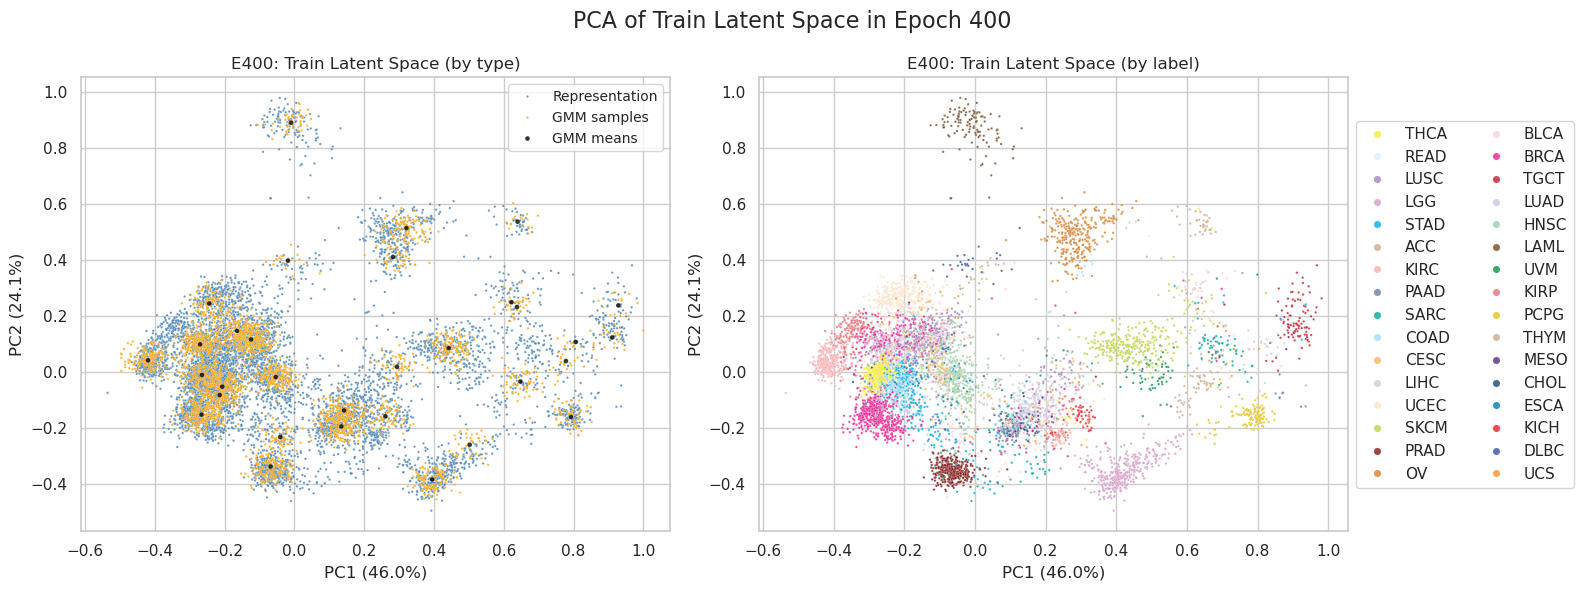

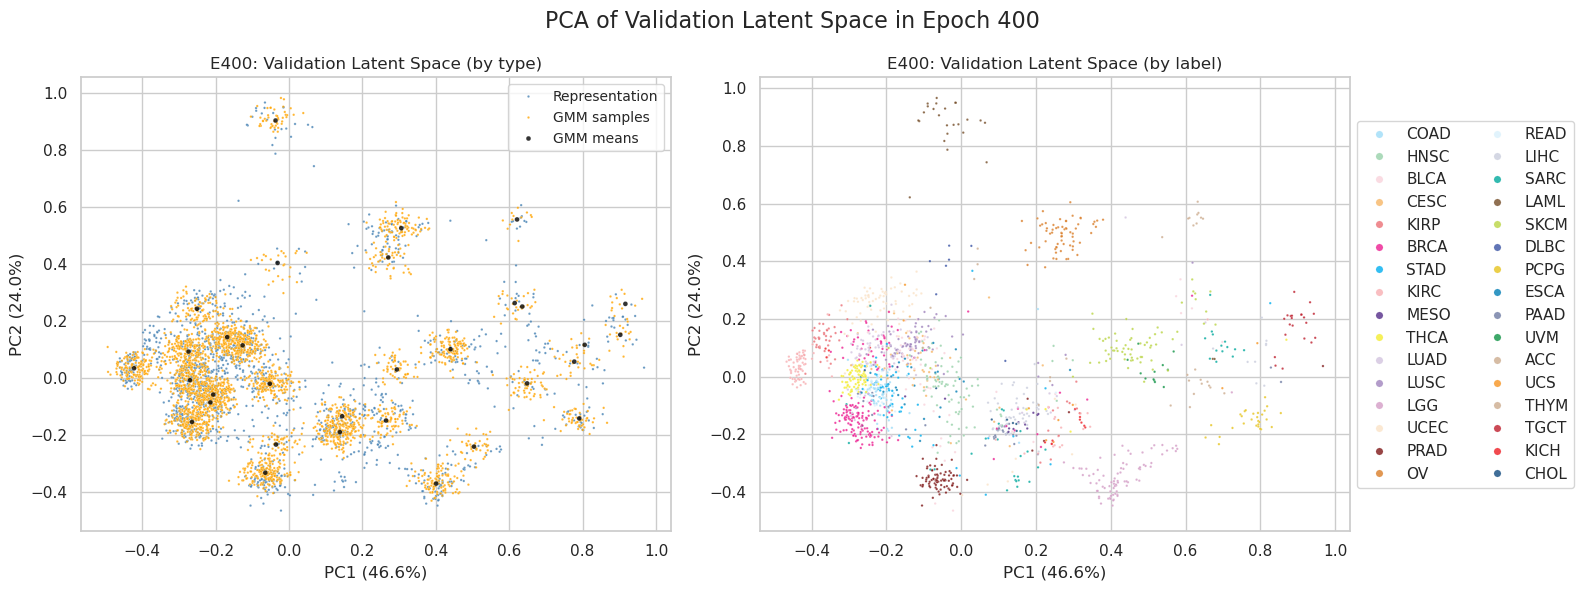

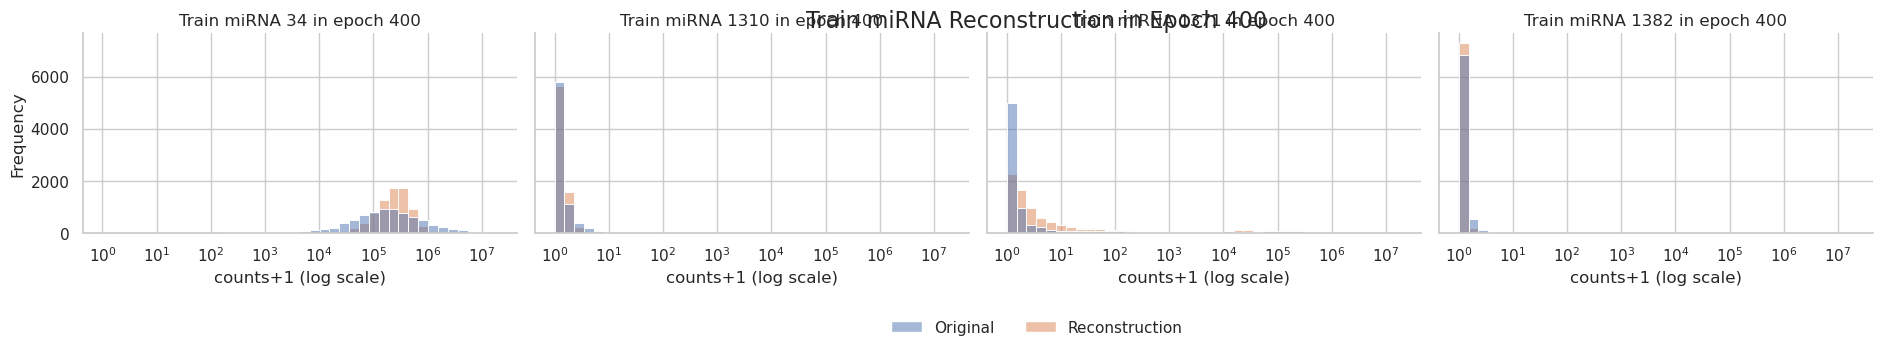

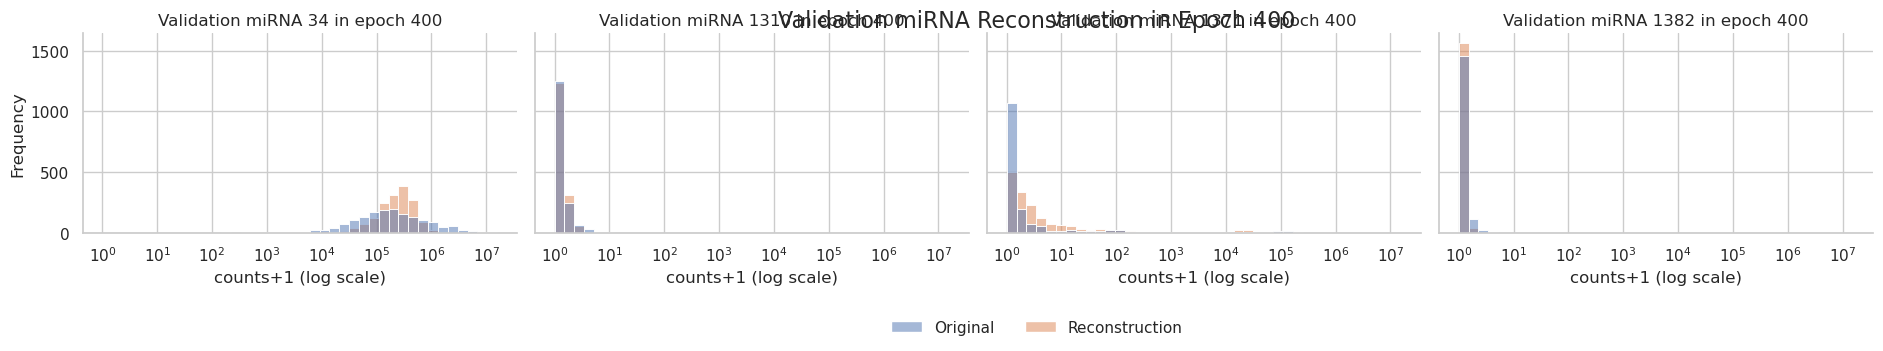

 51%|██████████████████████████████████████████████████████████████▎                                                            | 406/801 [09:40<12:49,  1.95s/it]

405 train_recon: 1.8332446866360532 train_gmm: 2.1653253895011626 train_mse: 600789376.0 train_mae: 3959.35205078125 train_r2: 0.25627487897872925 train_spearman: 0.4614795446395874 train_pearson: 0.8881024718284607 train_msle: 1.910652995109558
405 test_recon: 1.829956212906089 test_gmm: 2.165323918644597 test_mse: 315270144.0 test_mae: 2875.607177734375 test_r2: 0.312261164188385 test_spearman: 0.4342016875743866 test_pearson: 0.8912807703018188 test_msle: 1.8604156970977783


 51%|███████████████████████████████████████████████████████████████                                                            | 411/801 [09:47<10:03,  1.55s/it]

410 train_recon: 1.8321986056093107 train_gmm: 2.1652310083880093 train_mse: 596667200.0 train_mae: 3944.682373046875 train_r2: 0.26137781143188477 train_spearman: 0.4643227458000183 train_pearson: 0.8891016840934753 train_msle: 1.9035125970840454
410 test_recon: 1.8287360552585095 test_gmm: 2.1653024629382025 test_mse: 315635584.0 test_mae: 2875.96826171875 test_r2: 0.31146395206451416 test_spearman: 0.4349103271961212 test_pearson: 0.894594132900238 test_msle: 1.772439956665039


 52%|███████████████████████████████████████████████████████████████▉                                                           | 416/801 [09:54<09:27,  1.47s/it]

415 train_recon: 1.8313888837512675 train_gmm: 2.1652043009129742 train_mse: 594932160.0 train_mae: 3933.26904296875 train_r2: 0.26352566480636597 train_spearman: 0.46422824263572693 train_pearson: 0.8870068788528442 train_msle: 1.9402052164077759
415 test_recon: 1.827494174952105 test_gmm: 2.1656094305073 test_mse: 314466016.0 test_mae: 2871.9951171875 test_r2: 0.31401532888412476 test_spearman: 0.43413737416267395 test_pearson: 0.8929734230041504 test_msle: 1.826346755027771


 53%|████████████████████████████████████████████████████████████████▋                                                          | 421/801 [10:02<09:10,  1.45s/it]

420 train_recon: 1.8306458256310332 train_gmm: 2.1651932275201142 train_mse: 593126784.0 train_mae: 3926.974853515625 train_r2: 0.26576054096221924 train_spearman: 0.4669792056083679 train_pearson: 0.8889697194099426 train_msle: 1.9094505310058594
420 test_recon: 1.8289423023807996 test_gmm: 2.1654526605075928 test_mse: 310619872.0 test_mae: 2847.86767578125 test_r2: 0.3224053978919983 test_spearman: 0.43931370973587036 test_pearson: 0.8943662643432617 test_msle: 1.7888836860656738


 53%|█████████████████████████████████████████████████████████████████▍                                                         | 426/801 [10:09<09:02,  1.45s/it]

425 train_recon: 1.82973135311165 train_gmm: 2.165149430528026 train_mse: 588128832.0 train_mae: 3906.1513671875 train_r2: 0.27194756269454956 train_spearman: 0.46479713916778564 train_pearson: 0.8880082368850708 train_msle: 1.9560587406158447
425 test_recon: 1.8258412759024745 test_gmm: 2.1652042805887923 test_mse: 310154784.0 test_mae: 2844.114990234375 test_r2: 0.3234199285507202 test_spearman: 0.43646255135536194 test_pearson: 0.8943874835968018 test_msle: 1.8024578094482422


 54%|██████████████████████████████████████████████████████████████████▏                                                        | 431/801 [10:16<09:01,  1.46s/it]

430 train_recon: 1.8287803163605714 train_gmm: 2.165117600444935 train_mse: 587905536.0 train_mae: 3906.59423828125 train_r2: 0.2722240090370178 train_spearman: 0.4695780575275421 train_pearson: 0.8892330527305603 train_msle: 1.8589593172073364
430 test_recon: 1.827378372205304 test_gmm: 2.1656267841632184 test_mse: 312530464.0 test_mae: 2861.414794921875 test_r2: 0.3182375431060791 test_spearman: 0.4350469410419464 test_pearson: 0.8973355293273926 test_msle: 1.7998031377792358


 54%|██████████████████████████████████████████████████████████████████▉                                                        | 436/801 [10:23<08:46,  1.44s/it]

435 train_recon: 1.8280185376016373 train_gmm: 2.1651107283747533 train_mse: 585818304.0 train_mae: 3896.503173828125 train_r2: 0.27480781078338623 train_spearman: 0.4648326337337494 train_pearson: 0.8899281024932861 train_msle: 1.9405364990234375
435 test_recon: 1.8247875895253214 test_gmm: 2.1652346799851654 test_mse: 305574720.0 test_mae: 2821.975341796875 test_r2: 0.3334110379219055 test_spearman: 0.44457876682281494 test_pearson: 0.8984289765357971 test_msle: 1.7540044784545898


 55%|███████████████████████████████████████████████████████████████████▋                                                       | 441/801 [10:31<08:40,  1.45s/it]

440 train_recon: 1.8273594733944043 train_gmm: 2.165075113507586 train_mse: 583403648.0 train_mae: 3886.3388671875 train_r2: 0.2777969241142273 train_spearman: 0.47082841396331787 train_pearson: 0.8890013694763184 train_msle: 1.845558762550354
440 test_recon: 1.8237027150999376 test_gmm: 2.1653638107042474 test_mse: 309395520.0 test_mae: 2844.486572265625 test_r2: 0.32507622241973877 test_spearman: 0.43892714381217957 test_pearson: 0.8972029089927673 test_msle: 1.7871103286743164


 56%|████████████████████████████████████████████████████████████████████▍                                                      | 446/801 [10:38<08:39,  1.46s/it]

445 train_recon: 1.826446037007932 train_gmm: 2.1650346520912787 train_mse: 583618752.0 train_mae: 3887.14501953125 train_r2: 0.2775306701660156 train_spearman: 0.47330182790756226 train_pearson: 0.8911693096160889 train_msle: 1.7816065549850464
445 test_recon: 1.8243981246744254 test_gmm: 2.165383840604993 test_mse: 309534784.0 test_mae: 2846.04541015625 test_r2: 0.3247724771499634 test_spearman: 0.43880993127822876 test_pearson: 0.8990498781204224 test_msle: 1.8321930170059204


 56%|█████████████████████████████████████████████████████████████████████▎                                                     | 451/801 [10:45<08:22,  1.44s/it]

450 train_recon: 1.8257050098321679 train_gmm: 2.164958337319036 train_mse: 579579584.0 train_mae: 3869.650146484375 train_r2: 0.28253084421157837 train_spearman: 0.4714786112308502 train_pearson: 0.890622079372406 train_msle: 1.84781014919281
450 test_recon: 1.8236699213590568 test_gmm: 2.165320411315194 test_mse: 305463296.0 test_mae: 2822.421630859375 test_r2: 0.33365410566329956 test_spearman: 0.4372297525405884 test_pearson: 0.896406352519989 test_msle: 1.8061808347702026


 57%|██████████████████████████████████████████████████████████████████████                                                     | 456/801 [10:52<08:20,  1.45s/it]

455 train_recon: 1.8250869198779638 train_gmm: 2.1650183858505203 train_mse: 578114944.0 train_mae: 3863.4736328125 train_r2: 0.2843438982963562 train_spearman: 0.4692022204399109 train_pearson: 0.8903488516807556 train_msle: 1.8466243743896484
455 test_recon: 1.8221558496280117 test_gmm: 2.16525365768709 test_mse: 305130976.0 test_mae: 2820.699951171875 test_r2: 0.33437901735305786 test_spearman: 0.436463326215744 test_pearson: 0.8981271386146545 test_msle: 1.787095069885254


 58%|██████████████████████████████████████████████████████████████████████▊                                                    | 461/801 [11:00<08:12,  1.45s/it]

460 train_recon: 1.8242460406871854 train_gmm: 2.164998062033738 train_mse: 576929408.0 train_mae: 3859.798583984375 train_r2: 0.28581148386001587 train_spearman: 0.4734576642513275 train_pearson: 0.8918536305427551 train_msle: 1.8247367143630981
460 test_recon: 1.8223685388085016 test_gmm: 2.1654080640517646 test_mse: 305871072.0 test_mae: 2829.315185546875 test_r2: 0.33276456594467163 test_spearman: 0.43542447686195374 test_pearson: 0.8985860347747803 test_msle: 1.8302264213562012


 58%|███████████████████████████████████████████████████████████████████████▌                                                   | 466/801 [11:07<08:04,  1.45s/it]

465 train_recon: 1.823779376960946 train_gmm: 2.165034413602511 train_mse: 575718016.0 train_mae: 3852.6650390625 train_r2: 0.2873110771179199 train_spearman: 0.4707185924053192 train_pearson: 0.8906360864639282 train_msle: 1.7958049774169922
465 test_recon: 1.8204786096279375 test_gmm: 2.165224081750664 test_mse: 298282464.0 test_mae: 2780.3740234375 test_r2: 0.3493185043334961 test_spearman: 0.4431096017360687 test_pearson: 0.8992084264755249 test_msle: 1.6571379899978638


 59%|████████████████████████████████████████████████████████████████████████▎                                                  | 471/801 [11:14<07:54,  1.44s/it]

470 train_recon: 1.8229236892305052 train_gmm: 2.1650127944323523 train_mse: 574498752.0 train_mae: 3845.535400390625 train_r2: 0.28882044553756714 train_spearman: 0.47330641746520996 train_pearson: 0.8906224370002747 train_msle: 1.762715220451355
470 test_recon: 1.8197430191619985 test_gmm: 2.1650879592466623 test_mse: 298355776.0 test_mae: 2780.900146484375 test_r2: 0.3491585850715637 test_spearman: 0.4426318407058716 test_pearson: 0.9005177617073059 test_msle: 1.7070322036743164


 59%|█████████████████████████████████████████████████████████████████████████                                                  | 476/801 [11:21<07:45,  1.43s/it]

475 train_recon: 1.8223301648202963 train_gmm: 2.165017600144374 train_mse: 571661696.0 train_mae: 3837.1533203125 train_r2: 0.2923324704170227 train_spearman: 0.4728162884712219 train_pearson: 0.8920958042144775 train_msle: 1.9339762926101685
475 test_recon: 1.8197533476714776 test_gmm: 2.1650156167654004 test_mse: 300025216.0 test_mae: 2789.595947265625 test_r2: 0.3455168604850769 test_spearman: 0.4402022659778595 test_pearson: 0.8986638784408569 test_msle: 1.6721484661102295


 60%|█████████████████████████████████████████████████████████████████████████▊                                                 | 481/801 [11:28<07:47,  1.46s/it]

480 train_recon: 1.8219043875392122 train_gmm: 2.1650528409435426 train_mse: 569500992.0 train_mae: 3826.507080078125 train_r2: 0.29500722885131836 train_spearman: 0.46909117698669434 train_pearson: 0.891150176525116 train_msle: 1.8454773426055908
480 test_recon: 1.8186819938532734 test_gmm: 2.1654047397134604 test_mse: 297780416.0 test_mae: 2778.69775390625 test_r2: 0.3504137396812439 test_spearman: 0.4378167390823364 test_pearson: 0.8977466225624084 test_msle: 1.7225780487060547


 61%|██████████████████████████████████████████████████████████████████████████▋                                                | 486/801 [11:36<07:36,  1.45s/it]

485 train_recon: 1.8212995131865362 train_gmm: 2.1650924300790138 train_mse: 570531904.0 train_mae: 3827.6279296875 train_r2: 0.29373103380203247 train_spearman: 0.4736608564853668 train_pearson: 0.8913787007331848 train_msle: 1.7836591005325317
485 test_recon: 1.8205087995428992 test_gmm: 2.165323201929458 test_mse: 300840320.0 test_mae: 2793.388916015625 test_r2: 0.3437387943267822 test_spearman: 0.4441455602645874 test_pearson: 0.8990610241889954 test_msle: 1.6553375720977783


 61%|███████████████████████████████████████████████████████████████████████████▍                                               | 491/801 [11:43<07:26,  1.44s/it]

490 train_recon: 1.8205638991079347 train_gmm: 2.1651257891037945 train_mse: 569817216.0 train_mae: 3826.1806640625 train_r2: 0.29461580514907837 train_spearman: 0.4729650020599365 train_pearson: 0.8906189799308777 train_msle: 1.7445329427719116
490 test_recon: 1.8176247296264316 test_gmm: 2.165003760467091 test_mse: 295048928.0 test_mae: 2762.90771484375 test_r2: 0.35637223720550537 test_spearman: 0.44270458817481995 test_pearson: 0.9013248085975647 test_msle: 1.6826950311660767


 62%|████████████████████████████████████████████████████████████████████████████▏                                              | 496/801 [11:50<07:19,  1.44s/it]

495 train_recon: 1.819943103638183 train_gmm: 2.1651591285267586 train_mse: 568451520.0 train_mae: 3819.612548828125 train_r2: 0.2963063716888428 train_spearman: 0.4774816632270813 train_pearson: 0.890511691570282 train_msle: 1.6565382480621338
495 test_recon: 1.8169585793402345 test_gmm: 2.1652727268845644 test_mse: 296655424.0 test_mae: 2770.074462890625 test_r2: 0.3528677821159363 test_spearman: 0.4428313672542572 test_pearson: 0.89778071641922 test_msle: 1.7175425291061401


 63%|████████████████████████████████████████████████████████████████████████████▉                                              | 501/801 [11:57<07:04,  1.42s/it]

500 train_recon: 1.8192165430678902 train_gmm: 2.1651633559851926 train_mse: 567233536.0 train_mae: 3816.945068359375 train_r2: 0.29781413078308105 train_spearman: 0.4775640070438385 train_pearson: 0.8921387195587158 train_msle: 1.7059688568115234
500 test_recon: 1.817928977041276 test_gmm: 2.165720414609033 test_mse: 297046336.0 test_mae: 2769.635986328125 test_r2: 0.35201507806777954 test_spearman: 0.4415338337421417 test_pearson: 0.8979994058609009 test_msle: 1.6011881828308105


 63%|█████████████████████████████████████████████████████████████████████████████▋                                             | 506/801 [12:04<06:48,  1.38s/it]

505 train_recon: 1.8187217539631475 train_gmm: 2.165202714799319 train_mse: 565098816.0 train_mae: 3806.021484375 train_r2: 0.3004567623138428 train_spearman: 0.4774034917354584 train_pearson: 0.8910855054855347 train_msle: 1.7036975622177124
505 test_recon: 1.8160095860526277 test_gmm: 2.1651853028868677 test_mse: 292117120.0 test_mae: 2740.216796875 test_r2: 0.36276775598526 test_spearman: 0.4491812586784363 test_pearson: 0.8986522555351257 test_msle: 1.6007895469665527


 64%|██████████████████████████████████████████████████████████████████████████████▍                                            | 511/801 [12:11<06:41,  1.39s/it]

510 train_recon: 1.8181082703067009 train_gmm: 2.165303102235757 train_mse: 563596608.0 train_mae: 3798.0849609375 train_r2: 0.3023163676261902 train_spearman: 0.47454729676246643 train_pearson: 0.8905742168426514 train_msle: 1.7282980680465698
510 test_recon: 1.8159434344085836 test_gmm: 2.1656940181429576 test_mse: 290260480.0 test_mae: 2728.52783203125 test_r2: 0.3668178915977478 test_spearman: 0.4472423195838928 test_pearson: 0.8985119462013245 test_msle: 1.5443732738494873


 64%|███████████████████████████████████████████████████████████████████████████████▏                                           | 516/801 [12:18<06:37,  1.39s/it]

515 train_recon: 1.817326038511368 train_gmm: 2.1653810537596807 train_mse: 563190528.0 train_mae: 3796.706298828125 train_r2: 0.30281901359558105 train_spearman: 0.4754861891269684 train_pearson: 0.8908383250236511 train_msle: 1.7367851734161377
515 test_recon: 1.8146995289042422 test_gmm: 2.165785574689647 test_mse: 291021536.0 test_mae: 2732.446044921875 test_r2: 0.3651577830314636 test_spearman: 0.44608160853385925 test_pearson: 0.8994200229644775 test_msle: 1.5720688104629517


 65%|████████████████████████████████████████████████████████████████████████████████                                           | 521/801 [12:25<06:26,  1.38s/it]

520 train_recon: 1.8168239158996102 train_gmm: 2.1654460435824174 train_mse: 560412864.0 train_mae: 3784.817626953125 train_r2: 0.30625754594802856 train_spearman: 0.474564790725708 train_pearson: 0.8917083740234375 train_msle: 1.774883508682251
520 test_recon: 1.8165293723907736 test_gmm: 2.1664123954510854 test_mse: 295807616.0 test_mae: 2761.42236328125 test_r2: 0.3547172546386719 test_spearman: 0.44492480158805847 test_pearson: 0.8989946246147156 test_msle: 1.6455519199371338


 66%|████████████████████████████████████████████████████████████████████████████████▊                                          | 526/801 [12:32<06:19,  1.38s/it]

525 train_recon: 1.816156882869569 train_gmm: 2.165533693105074 train_mse: 560208448.0 train_mae: 3785.151611328125 train_r2: 0.3065105676651001 train_spearman: 0.4757434129714966 train_pearson: 0.891313910484314 train_msle: 1.7357428073883057
525 test_recon: 1.8142510729305794 test_gmm: 2.166226141010501 test_mse: 292981408.0 test_mae: 2749.76025390625 test_r2: 0.36088240146636963 test_spearman: 0.44515693187713623 test_pearson: 0.9002669453620911 test_msle: 1.7038816213607788


 66%|█████████████████████████████████████████████████████████████████████████████████▌                                         | 531/801 [12:39<06:13,  1.38s/it]

530 train_recon: 1.815558011476361 train_gmm: 2.165604022789333 train_mse: 560500672.0 train_mae: 3785.68115234375 train_r2: 0.30614882707595825 train_spearman: 0.4741038382053375 train_pearson: 0.8930031657218933 train_msle: 1.6882610321044922
530 test_recon: 1.8132896632508586 test_gmm: 2.1659001118685586 test_mse: 294386176.0 test_mae: 2758.623779296875 test_r2: 0.35781800746917725 test_spearman: 0.4438435435295105 test_pearson: 0.9029597640037537 test_msle: 1.6323201656341553


 67%|██████████████████████████████████████████████████████████████████████████████████▎                                        | 536/801 [12:46<06:11,  1.40s/it]

535 train_recon: 1.8149047208950906 train_gmm: 2.1657899574536037 train_mse: 558385408.0 train_mae: 3775.83740234375 train_r2: 0.30876731872558594 train_spearman: 0.4765918552875519 train_pearson: 0.8905429840087891 train_msle: 1.714874267578125
535 test_recon: 1.813963012633532 test_gmm: 2.1664517537866956 test_mse: 292300576.0 test_mae: 2739.84521484375 test_r2: 0.3623676300048828 test_spearman: 0.4508778750896454 test_pearson: 0.8975757956504822 test_msle: 1.6299574375152588


 68%|███████████████████████████████████████████████████████████████████████████████████                                        | 541/801 [12:53<06:03,  1.40s/it]

540 train_recon: 1.8143192014638734 train_gmm: 2.1658744788530377 train_mse: 557661760.0 train_mae: 3772.29541015625 train_r2: 0.30966317653656006 train_spearman: 0.47413745522499084 train_pearson: 0.8916582465171814 train_msle: 1.7962769269943237
540 test_recon: 1.8116444647752887 test_gmm: 2.1661837938202684 test_mse: 285853856.0 test_mae: 2700.46044921875 test_r2: 0.3764306306838989 test_spearman: 0.44561320543289185 test_pearson: 0.8997937440872192 test_msle: 1.5909411907196045


 68%|███████████████████████████████████████████████████████████████████████████████████▊                                       | 546/801 [13:00<05:58,  1.41s/it]

545 train_recon: 1.8137984305257822 train_gmm: 2.1660330640827814 train_mse: 558636736.0 train_mae: 3775.490234375 train_r2: 0.3084562420845032 train_spearman: 0.47506260871887207 train_pearson: 0.8898369073867798 train_msle: 1.7223193645477295
545 test_recon: 1.812393850696699 test_gmm: 2.166005621486571 test_mse: 291173600.0 test_mae: 2737.680908203125 test_r2: 0.364825963973999 test_spearman: 0.446113258600235 test_pearson: 0.8977517485618591 test_msle: 1.6336942911148071


 69%|████████████████████████████████████████████████████████████████████████████████████▌                                      | 551/801 [13:07<05:45,  1.38s/it]

550 train_recon: 1.8129513097447252 train_gmm: 2.1661372738734443 train_mse: 558886272.0 train_mae: 3777.202392578125 train_r2: 0.3081473708152771 train_spearman: 0.4769229590892792 train_pearson: 0.8918536305427551 train_msle: 1.6331607103347778
550 test_recon: 1.8116764002179961 test_gmm: 2.1670986044488796 test_mse: 290632512.0 test_mae: 2728.587890625 test_r2: 0.36600637435913086 test_spearman: 0.4489615857601166 test_pearson: 0.8981117010116577 test_msle: 1.6207208633422852


 69%|█████████████████████████████████████████████████████████████████████████████████████▍                                     | 556/801 [13:14<05:38,  1.38s/it]

555 train_recon: 1.8124442327028158 train_gmm: 2.166281927112083 train_mse: 556464832.0 train_mae: 3764.028076171875 train_r2: 0.3111448287963867 train_spearman: 0.47790783643722534 train_pearson: 0.8903372883796692 train_msle: 1.671547532081604
555 test_recon: 1.8115711092128683 test_gmm: 2.166767878535388 test_mse: 287429760.0 test_mae: 2711.529541015625 test_r2: 0.3729928731918335 test_spearman: 0.45027413964271545 test_pearson: 0.8980191349983215 test_msle: 1.5211143493652344


 70%|██████████████████████████████████████████████████████████████████████████████████████▏                                    | 561/801 [13:21<05:25,  1.36s/it]

560 train_recon: 1.8117052953544486 train_gmm: 2.166419308076785 train_mse: 556121280.0 train_mae: 3765.3154296875 train_r2: 0.31157010793685913 train_spearman: 0.480221152305603 train_pearson: 0.8905494809150696 train_msle: 1.6663446426391602
560 test_recon: 1.8109904753205137 test_gmm: 2.1669158649623284 test_mse: 293553568.0 test_mae: 2748.04541015625 test_r2: 0.35963428020477295 test_spearman: 0.44584137201309204 test_pearson: 0.8995736837387085 test_msle: 1.6673102378845215


 71%|██████████████████████████████████████████████████████████████████████████████████████▉                                    | 566/801 [13:28<05:25,  1.38s/it]

565 train_recon: 1.8111211746510099 train_gmm: 2.1666044766367256 train_mse: 556256768.0 train_mae: 3764.5078125 train_r2: 0.31140244007110596 train_spearman: 0.48104825615882874 train_pearson: 0.8905395865440369 train_msle: 1.713921070098877
565 test_recon: 1.8089965908010803 test_gmm: 2.167055761657753 test_mse: 287435168.0 test_mae: 2707.22314453125 test_r2: 0.37298113107681274 test_spearman: 0.44614800810813904 test_pearson: 0.895595371723175 test_msle: 1.5538324117660522


 71%|███████████████████████████████████████████████████████████████████████████████████████▋                                   | 571/801 [13:35<05:23,  1.41s/it]

570 train_recon: 1.8104566901153771 train_gmm: 2.1667910793962433 train_mse: 553765056.0 train_mae: 3754.58349609375 train_r2: 0.31448692083358765 train_spearman: 0.4790598154067993 train_pearson: 0.8902921080589294 train_msle: 1.6775181293487549
570 test_recon: 1.8090646374517656 test_gmm: 2.1670815481534977 test_mse: 290263872.0 test_mae: 2726.988037109375 test_r2: 0.36681050062179565 test_spearman: 0.44859442114830017 test_pearson: 0.899599015712738 test_msle: 1.6855366230010986


 72%|████████████████████████████████████████████████████████████████████████████████████████▍                                  | 576/801 [13:42<05:11,  1.39s/it]

575 train_recon: 1.809930656903059 train_gmm: 2.166835354999352 train_mse: 556514752.0 train_mae: 3763.933349609375 train_r2: 0.3110830783843994 train_spearman: 0.47779855132102966 train_pearson: 0.8900126218795776 train_msle: 1.7094162702560425
575 test_recon: 1.8106238518092077 test_gmm: 2.167814366509213 test_mse: 284621088.0 test_mae: 2695.716796875 test_r2: 0.379119873046875 test_spearman: 0.44458475708961487 test_pearson: 0.8986378908157349 test_msle: 1.5538314580917358


 73%|█████████████████████████████████████████████████████████████████████████████████████████▏                                 | 581/801 [13:49<05:07,  1.40s/it]

580 train_recon: 1.8091171675707118 train_gmm: 2.166995229048533 train_mse: 558656704.0 train_mae: 3773.248046875 train_r2: 0.3084315061569214 train_spearman: 0.4761652648448944 train_pearson: 0.8895912170410156 train_msle: 1.5939018726348877
580 test_recon: 1.8069858585635707 test_gmm: 2.1676567044278965 test_mse: 289325024.0 test_mae: 2720.290283203125 test_r2: 0.36885857582092285 test_spearman: 0.4511229991912842 test_pearson: 0.9006551504135132 test_msle: 1.5773108005523682


 73%|█████████████████████████████████████████████████████████████████████████████████████████▉                                 | 586/801 [13:55<04:56,  1.38s/it]

585 train_recon: 1.8084781638470298 train_gmm: 2.1671298543245268 train_mse: 553483776.0 train_mae: 3752.567138671875 train_r2: 0.3148351311683655 train_spearman: 0.4812505543231964 train_pearson: 0.8898813128471375 train_msle: 1.6761687994003296
585 test_recon: 1.8079041459929317 test_gmm: 2.1678706820200264 test_mse: 288759232.0 test_mae: 2719.923583984375 test_r2: 0.3700927495956421 test_spearman: 0.4497717320919037 test_pearson: 0.9013655781745911 test_msle: 1.6192861795425415


 74%|██████████████████████████████████████████████████████████████████████████████████████████▊                                | 591/801 [14:02<04:52,  1.40s/it]

590 train_recon: 1.807736059217002 train_gmm: 2.167263127075179 train_mse: 554525120.0 train_mae: 3757.468505859375 train_r2: 0.31354600191116333 train_spearman: 0.4797372817993164 train_pearson: 0.8899296522140503 train_msle: 1.6356364488601685
590 test_recon: 1.8062056655240177 test_gmm: 2.1678162269187227 test_mse: 284701088.0 test_mae: 2693.409912109375 test_r2: 0.37894535064697266 test_spearman: 0.45122388005256653 test_pearson: 0.8984126448631287 test_msle: 1.5842113494873047


 74%|███████████████████████████████████████████████████████████████████████████████████████████▌                               | 596/801 [14:09<04:44,  1.39s/it]

595 train_recon: 1.8071753594560973 train_gmm: 2.1673583951705306 train_mse: 554351488.0 train_mae: 3751.798583984375 train_r2: 0.31376099586486816 train_spearman: 0.4810045659542084 train_pearson: 0.889642596244812 train_msle: 1.5462877750396729
595 test_recon: 1.8052586926124483 test_gmm: 2.1675985437568315 test_mse: 288361536.0 test_mae: 2710.248779296875 test_r2: 0.3709603548049927 test_spearman: 0.45110028982162476 test_pearson: 0.9001832008361816 test_msle: 1.5698059797286987


 75%|████████████████████████████████████████████████████████████████████████████████████████████▎                              | 601/801 [14:16<04:36,  1.38s/it]

600 train_recon: 1.8065428142597937 train_gmm: 2.167393421983202 train_mse: 555131840.0 train_mae: 3756.4111328125 train_r2: 0.31279492378234863 train_spearman: 0.4835095703601837 train_pearson: 0.889394998550415 train_msle: 1.5799636840820312
600 test_recon: 1.804396209030053 test_gmm: 2.1676228815730405 test_mse: 286289824.0 test_mae: 2696.338623046875 test_r2: 0.3754795789718628 test_spearman: 0.45394840836524963 test_pearson: 0.8973780870437622 test_msle: 1.5349162817001343


 76%|█████████████████████████████████████████████████████████████████████████████████████████████                              | 606/801 [14:23<04:26,  1.37s/it]

605 train_recon: 1.8061044298340958 train_gmm: 2.1675383855839354 train_mse: 551216512.0 train_mae: 3740.644775390625 train_r2: 0.3176417946815491 train_spearman: 0.48328813910484314 train_pearson: 0.8904101848602295 train_msle: 1.5781126022338867
605 test_recon: 1.8045138392768971 test_gmm: 2.1679931945610167 test_mse: 287381728.0 test_mae: 2707.998291015625 test_r2: 0.37309765815734863 test_spearman: 0.44912993907928467 test_pearson: 0.9009749293327332 test_msle: 1.5399564504623413


 76%|█████████████████████████████████████████████████████████████████████████████████████████████▊                             | 611/801 [14:30<04:25,  1.40s/it]

610 train_recon: 1.8054690778849312 train_gmm: 2.1675648839729273 train_mse: 551081472.0 train_mae: 3741.00341796875 train_r2: 0.31780898571014404 train_spearman: 0.47941240668296814 train_pearson: 0.8909151554107666 train_msle: 1.7016149759292603
610 test_recon: 1.8045999873396197 test_gmm: 2.1682149645241258 test_mse: 283785760.0 test_mae: 2687.0126953125 test_r2: 0.38094204664230347 test_spearman: 0.45099103450775146 test_pearson: 0.898949921131134 test_msle: 1.581094741821289


 77%|██████████████████████████████████████████████████████████████████████████████████████████████▌                            | 616/801 [14:37<04:20,  1.41s/it]

615 train_recon: 1.804950419500981 train_gmm: 2.167607246765439 train_mse: 552014784.0 train_mae: 3746.51611328125 train_r2: 0.31665366888046265 train_spearman: 0.48367103934288025 train_pearson: 0.8911744356155396 train_msle: 1.5939640998840332
615 test_recon: 1.8050994493698973 test_gmm: 2.1677613753367035 test_mse: 284263840.0 test_mae: 2693.7890625 test_r2: 0.37989920377731323 test_spearman: 0.4515573978424072 test_pearson: 0.9023866653442383 test_msle: 1.484527587890625


 78%|███████████████████████████████████████████████████████████████████████████████████████████████▎                           | 621/801 [14:44<04:09,  1.39s/it]

620 train_recon: 1.8043335350972327 train_gmm: 2.167688192466839 train_mse: 550138752.0 train_mae: 3734.8505859375 train_r2: 0.3189759850502014 train_spearman: 0.4839577078819275 train_pearson: 0.890316367149353 train_msle: 1.5857641696929932
620 test_recon: 1.8032134355720115 test_gmm: 2.1679058773081277 test_mse: 281791264.0 test_mae: 2673.320556640625 test_r2: 0.3852928876876831 test_spearman: 0.4527125060558319 test_pearson: 0.8984265327453613 test_msle: 1.501123309135437


 78%|████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 626/801 [14:51<04:02,  1.38s/it]

625 train_recon: 1.8037298404691673 train_gmm: 2.1677585531873076 train_mse: 550935168.0 train_mae: 3736.626708984375 train_r2: 0.3179900646209717 train_spearman: 0.48363396525382996 train_pearson: 0.8890357613563538 train_msle: 1.6362898349761963
625 test_recon: 1.8039306594214215 test_gmm: 2.1680742214948663 test_mse: 280785792.0 test_mae: 2670.40234375 test_r2: 0.3874862790107727 test_spearman: 0.44737863540649414 test_pearson: 0.8975903987884521 test_msle: 1.4872186183929443


 79%|████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 631/801 [14:58<04:00,  1.42s/it]

630 train_recon: 1.8031918819145498 train_gmm: 2.167730891757201 train_mse: 556277184.0 train_mae: 3761.467041015625 train_r2: 0.3113771677017212 train_spearman: 0.48498281836509705 train_pearson: 0.889904260635376 train_msle: 1.5346380472183228
630 test_recon: 1.8028146740982045 test_gmm: 2.168494254689452 test_mse: 285131392.0 test_mae: 2691.4111328125 test_r2: 0.37800663709640503 test_spearman: 0.45352914929389954 test_pearson: 0.8981680274009705 test_msle: 1.4776703119277954


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 636/801 [15:05<03:52,  1.41s/it]

635 train_recon: 1.8028178234711496 train_gmm: 2.167766815352979 train_mse: 550534592.0 train_mae: 3738.595947265625 train_r2: 0.31848597526550293 train_spearman: 0.4809894561767578 train_pearson: 0.8893141746520996 train_msle: 1.689362645149231
635 test_recon: 1.806122936188289 test_gmm: 2.16770196422646 test_mse: 279128352.0 test_mae: 2660.633056640625 test_r2: 0.3911018371582031 test_spearman: 0.45039331912994385 test_pearson: 0.9002691507339478 test_msle: 1.534040927886963


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 641/801 [15:12<03:43,  1.39s/it]

640 train_recon: 1.8021657312090984 train_gmm: 2.1678365259465324 train_mse: 549276480.0 train_mae: 3728.5087890625 train_r2: 0.3200433850288391 train_spearman: 0.48595595359802246 train_pearson: 0.8891527652740479 train_msle: 1.5614441633224487
640 test_recon: 1.8002852549157147 test_gmm: 2.167901264407499 test_mse: 284710208.0 test_mae: 2689.418212890625 test_r2: 0.3789254426956177 test_spearman: 0.45490458607673645 test_pearson: 0.9004884362220764 test_msle: 1.5384749174118042


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 646/801 [15:19<03:37,  1.40s/it]

645 train_recon: 1.8018065815096402 train_gmm: 2.167767187787493 train_mse: 549274752.0 train_mae: 3729.724853515625 train_r2: 0.3200455904006958 train_spearman: 0.4814620912075043 train_pearson: 0.8887161612510681 train_msle: 1.638373613357544
645 test_recon: 1.8018285907569502 test_gmm: 2.16809612705438 test_mse: 281221952.0 test_mae: 2664.36865234375 test_r2: 0.38653481006622314 test_spearman: 0.4551851749420166 test_pearson: 0.8989918828010559 test_msle: 1.517149806022644


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 651/801 [15:26<03:29,  1.40s/it]

650 train_recon: 1.8010476735516634 train_gmm: 2.1678262284589103 train_mse: 549135744.0 train_mae: 3732.86328125 train_r2: 0.3202176094055176 train_spearman: 0.48351097106933594 train_pearson: 0.8904338479042053 train_msle: 1.589801549911499
650 test_recon: 1.8017964335068497 test_gmm: 2.1682519820985906 test_mse: 278776000.0 test_mae: 2656.021728515625 test_r2: 0.39187049865722656 test_spearman: 0.4528185725212097 test_pearson: 0.8973622918128967 test_msle: 1.5106585025787354


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 656/801 [15:33<03:20,  1.39s/it]

655 train_recon: 1.8006714137132147 train_gmm: 2.167822249290153 train_mse: 547037696.0 train_mae: 3719.51416015625 train_r2: 0.32281482219696045 train_spearman: 0.4836128354072571 train_pearson: 0.8899087905883789 train_msle: 1.6216202974319458
655 test_recon: 1.80272375717653 test_gmm: 2.1679737060089397 test_mse: 276709792.0 test_mae: 2642.32275390625 test_r2: 0.3963777422904968 test_spearman: 0.4546966850757599 test_pearson: 0.8979235291481018 test_msle: 1.4133976697921753


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 661/801 [15:40<03:15,  1.40s/it]

660 train_recon: 1.800348744569713 train_gmm: 2.1678630031002233 train_mse: 549259584.0 train_mae: 3728.715576171875 train_r2: 0.3200643062591553 train_spearman: 0.48058438301086426 train_pearson: 0.8895688056945801 train_msle: 1.6386462450027466
660 test_recon: 1.7993213233823722 test_gmm: 2.1684627954696283 test_mse: 281926112.0 test_mae: 2673.10546875 test_r2: 0.38499873876571655 test_spearman: 0.4527003765106201 test_pearson: 0.8996094465255737 test_msle: 1.479480504989624


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 666/801 [15:47<03:11,  1.42s/it]

665 train_recon: 1.7998110762975963 train_gmm: 2.1678211417875186 train_mse: 547631232.0 train_mae: 3720.98388671875 train_r2: 0.3220800757408142 train_spearman: 0.48451340198516846 train_pearson: 0.8881943225860596 train_msle: 1.493277668952942
665 test_recon: 1.799721218002644 test_gmm: 2.1681665328798405 test_mse: 278664000.0 test_mae: 2651.134521484375 test_r2: 0.3921148180961609 test_spearman: 0.45372170209884644 test_pearson: 0.8966193795204163 test_msle: 1.4671326875686646


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████                    | 671/801 [15:54<02:59,  1.38s/it]

670 train_recon: 1.7994190771560226 train_gmm: 2.167846335022226 train_mse: 547722944.0 train_mae: 3721.721923828125 train_r2: 0.3219665288925171 train_spearman: 0.48638203740119934 train_pearson: 0.8887283205986023 train_msle: 1.5612751245498657
670 test_recon: 1.7993352104539406 test_gmm: 2.1678656650140535 test_mse: 278248288.0 test_mae: 2650.768798828125 test_r2: 0.3930216431617737 test_spearman: 0.4545961022377014 test_pearson: 0.8984694480895996 test_msle: 1.4434493780136108


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 676/801 [16:01<02:52,  1.38s/it]

675 train_recon: 1.7989053948959337 train_gmm: 2.1677811312129918 train_mse: 547054272.0 train_mae: 3719.123046875 train_r2: 0.3227943181991577 train_spearman: 0.4880024790763855 train_pearson: 0.8899604678153992 train_msle: 1.507578730583191
675 test_recon: 1.7973989476377166 test_gmm: 2.168071255514132 test_mse: 280462336.0 test_mae: 2662.117431640625 test_r2: 0.3881918787956238 test_spearman: 0.4549058973789215 test_pearson: 0.8982693552970886 test_msle: 1.457760214805603


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 681/801 [16:08<02:46,  1.39s/it]

680 train_recon: 1.7984218338356688 train_gmm: 2.167882377862388 train_mse: 547951488.0 train_mae: 3722.966796875 train_r2: 0.3216835856437683 train_spearman: 0.48618704080581665 train_pearson: 0.8890158534049988 train_msle: 1.502982497215271
680 test_recon: 1.7974453777113735 test_gmm: 2.1682282771266004 test_mse: 279849184.0 test_mae: 2661.85498046875 test_r2: 0.38952940702438354 test_spearman: 0.4620351791381836 test_pearson: 0.8967161774635315 test_msle: 1.4196327924728394


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 686/801 [16:15<02:37,  1.37s/it]

685 train_recon: 1.7980166180595334 train_gmm: 2.1678235332091362 train_mse: 544191936.0 train_mae: 3704.8974609375 train_r2: 0.32633763551712036 train_spearman: 0.4846854507923126 train_pearson: 0.8896248936653137 train_msle: 1.4773783683776855
685 test_recon: 1.8048205072854664 test_gmm: 2.1684194952007534 test_mse: 280118080.0 test_mae: 2656.022705078125 test_r2: 0.38894277811050415 test_spearman: 0.45686566829681396 test_pearson: 0.8996862173080444 test_msle: 1.4200326204299927


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 691/801 [16:22<02:32,  1.39s/it]

690 train_recon: 1.7974568583593955 train_gmm: 2.167902058086194 train_mse: 548759360.0 train_mae: 3728.598876953125 train_r2: 0.3206835389137268 train_spearman: 0.4810831546783447 train_pearson: 0.8902000784873962 train_msle: 1.5421375036239624
690 test_recon: 1.7970723266075674 test_gmm: 2.1682598278419736 test_mse: 276115776.0 test_mae: 2640.587158203125 test_r2: 0.3976735472679138 test_spearman: 0.45783019065856934 test_pearson: 0.8970705270767212 test_msle: 1.4467716217041016


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 696/801 [16:29<02:26,  1.40s/it]

695 train_recon: 1.797067481057631 train_gmm: 2.16788287770871 train_mse: 542384896.0 train_mae: 3699.002197265625 train_r2: 0.32857459783554077 train_spearman: 0.4863108694553375 train_pearson: 0.8897757530212402 train_msle: 1.5524699687957764
695 test_recon: 1.7967142667903953 test_gmm: 2.1683844752791224 test_mse: 277209664.0 test_mae: 2650.6357421875 test_r2: 0.39528727531433105 test_spearman: 0.4555708169937134 test_pearson: 0.9018346667289734 test_msle: 1.3737578392028809


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 701/801 [16:36<02:21,  1.41s/it]

700 train_recon: 1.7968508125463791 train_gmm: 2.1679094969755703 train_mse: 544774912.0 train_mae: 3706.062744140625 train_r2: 0.32561594247817993 train_spearman: 0.4838952422142029 train_pearson: 0.8893904685974121 train_msle: 1.5988059043884277
700 test_recon: 1.7956118310057572 test_gmm: 2.1679361775843224 test_mse: 276963008.0 test_mae: 2643.19189453125 test_r2: 0.3958253860473633 test_spearman: 0.4540899693965912 test_pearson: 0.8980419039726257 test_msle: 1.417042851448059


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 706/801 [16:43<02:12,  1.40s/it]

705 train_recon: 1.7962608655322534 train_gmm: 2.1678587152028554 train_mse: 539495104.0 train_mae: 3683.533447265625 train_r2: 0.3321518898010254 train_spearman: 0.48678988218307495 train_pearson: 0.8884304761886597 train_msle: 1.5102370977401733
705 test_recon: 1.796044167368221 test_gmm: 2.1676283103089866 test_mse: 276838048.0 test_mae: 2644.028564453125 test_r2: 0.3960980176925659 test_spearman: 0.45454394817352295 test_pearson: 0.8978661894798279 test_msle: 1.4526119232177734


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 711/801 [16:50<02:06,  1.40s/it]

710 train_recon: 1.7960390256537502 train_gmm: 2.1678215991632377 train_mse: 543823424.0 train_mae: 3702.990966796875 train_r2: 0.3267937898635864 train_spearman: 0.4844913184642792 train_pearson: 0.8892512917518616 train_msle: 1.4719066619873047
710 test_recon: 1.7952420829033484 test_gmm: 2.167728261572357 test_mse: 278169312.0 test_mae: 2655.725830078125 test_r2: 0.39319396018981934 test_spearman: 0.4542873203754425 test_pearson: 0.9018057584762573 test_msle: 1.4128246307373047


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 716/801 [16:56<01:57,  1.38s/it]

715 train_recon: 1.7955848657687437 train_gmm: 2.16788131773081 train_mse: 541314688.0 train_mae: 3694.00439453125 train_r2: 0.3298994302749634 train_spearman: 0.4823385775089264 train_pearson: 0.8898722529411316 train_msle: 1.6081327199935913
715 test_recon: 1.7949028718926905 test_gmm: 2.1685208341466273 test_mse: 275444672.0 test_mae: 2639.248779296875 test_r2: 0.39913755655288696 test_spearman: 0.4577789008617401 test_pearson: 0.9003929495811462 test_msle: 1.4681600332260132


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 721/801 [17:04<01:52,  1.41s/it]

720 train_recon: 1.795200114392379 train_gmm: 2.167835186489069 train_mse: 539562048.0 train_mae: 3687.33447265625 train_r2: 0.3320690393447876 train_spearman: 0.4854198396205902 train_pearson: 0.8896461725234985 train_msle: 1.580004334449768
720 test_recon: 1.7933827534992335 test_gmm: 2.1678543348151544 test_mse: 276377184.0 test_mae: 2641.34033203125 test_r2: 0.39710330963134766 test_spearman: 0.4585983455181122 test_pearson: 0.8974151611328125 test_msle: 1.4475640058517456


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 726/801 [17:11<01:48,  1.45s/it]

725 train_recon: 1.7947482705691742 train_gmm: 2.1678030427769137 train_mse: 542748608.0 train_mae: 3699.462646484375 train_r2: 0.32812434434890747 train_spearman: 0.48515772819519043 train_pearson: 0.8897711038589478 train_msle: 1.512413740158081
725 test_recon: 1.795697525809894 test_gmm: 2.1679674080652718 test_mse: 277083136.0 test_mae: 2645.4892578125 test_r2: 0.39556336402893066 test_spearman: 0.4581142067909241 test_pearson: 0.8996211290359497 test_msle: 1.444929838180542


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 731/801 [17:18<01:40,  1.44s/it]

730 train_recon: 1.7944371001250086 train_gmm: 2.167768646489341 train_mse: 542356288.0 train_mae: 3700.2578125 train_r2: 0.32861000299453735 train_spearman: 0.4863540530204773 train_pearson: 0.8894602060317993 train_msle: 1.508762001991272
730 test_recon: 1.793220245830484 test_gmm: 2.167988863771666 test_mse: 277396800.0 test_mae: 2647.083740234375 test_r2: 0.3948791027069092 test_spearman: 0.45795339345932007 test_pearson: 0.8996021747589111 test_msle: 1.4560129642486572


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 736/801 [17:25<01:33,  1.44s/it]

735 train_recon: 1.7940915895709402 train_gmm: 2.1677972863767896 train_mse: 538246208.0 train_mae: 3674.082763671875 train_r2: 0.33369797468185425 train_spearman: 0.4847508668899536 train_pearson: 0.8876716494560242 train_msle: 1.5690250396728516
735 test_recon: 1.7935677890840829 test_gmm: 2.168256869485868 test_mse: 277088448.0 test_mae: 2642.721435546875 test_r2: 0.39555174112319946 test_spearman: 0.46061789989471436 test_pearson: 0.8981758952140808 test_msle: 1.4124399423599243


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 741/801 [17:33<01:26,  1.44s/it]

740 train_recon: 1.7935381933590702 train_gmm: 2.16775511470199 train_mse: 538465472.0 train_mae: 3677.39990234375 train_r2: 0.33342647552490234 train_spearman: 0.4873703420162201 train_pearson: 0.8885830640792847 train_msle: 1.5176162719726562
740 test_recon: 1.7935847573496555 test_gmm: 2.167865924251444 test_mse: 276398304.0 test_mae: 2644.138427734375 test_r2: 0.3970572352409363 test_spearman: 0.4582543671131134 test_pearson: 0.8977828621864319 test_msle: 1.469920039176941


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 746/801 [17:40<01:19,  1.44s/it]

745 train_recon: 1.7932337231721946 train_gmm: 2.1677755610301253 train_mse: 534781312.0 train_mae: 3664.201171875 train_r2: 0.33798718452453613 train_spearman: 0.48339012265205383 train_pearson: 0.8883313536643982 train_msle: 1.6133543252944946
745 test_recon: 1.795082048869222 test_gmm: 2.167990632685626 test_mse: 271687264.0 test_mae: 2616.1337890625 test_r2: 0.40733402967453003 test_spearman: 0.45750972628593445 test_pearson: 0.8972360491752625 test_msle: 1.433453917503357


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 751/801 [17:47<01:12,  1.45s/it]

750 train_recon: 1.792999148052885 train_gmm: 2.167760209540805 train_mse: 538569280.0 train_mae: 3678.176025390625 train_r2: 0.3332980275154114 train_spearman: 0.48686009645462036 train_pearson: 0.8876816034317017 train_msle: 1.5234919786453247
750 test_recon: 1.7921145166882482 test_gmm: 2.167931572308323 test_mse: 280200224.0 test_mae: 2659.729736328125 test_r2: 0.3887636065483093 test_spearman: 0.46045568585395813 test_pearson: 0.8964125514030457 test_msle: 1.4625670909881592


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 756/801 [17:54<01:04,  1.44s/it]

755 train_recon: 1.792618014360922 train_gmm: 2.1677989982687675 train_mse: 537204224.0 train_mae: 3675.62841796875 train_r2: 0.3349878191947937 train_spearman: 0.48706749081611633 train_pearson: 0.8888154625892639 train_msle: 1.4971507787704468
755 test_recon: 1.7934887629674388 test_gmm: 2.1683116295723375 test_mse: 274504160.0 test_mae: 2630.77880859375 test_r2: 0.4011892080307007 test_spearman: 0.46450307965278625 test_pearson: 0.8965365886688232 test_msle: 1.410007119178772


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 761/801 [18:01<00:56,  1.41s/it]

760 train_recon: 1.7923443740350637 train_gmm: 2.1678220892086513 train_mse: 536815648.0 train_mae: 3671.237060546875 train_r2: 0.3354688286781311 train_spearman: 0.4846589267253876 train_pearson: 0.8876902461051941 train_msle: 1.5107985734939575
760 test_recon: 1.7927956196858805 test_gmm: 2.1680474209234464 test_mse: 274407808.0 test_mae: 2633.697509765625 test_r2: 0.4013993740081787 test_spearman: 0.4615231454372406 test_pearson: 0.9014113545417786 test_msle: 1.4417169094085693


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 766/801 [18:08<00:49,  1.41s/it]

765 train_recon: 1.7917895697981112 train_gmm: 2.16780363083141 train_mse: 542171904.0 train_mae: 3698.1279296875 train_r2: 0.3288382887840271 train_spearman: 0.48594456911087036 train_pearson: 0.8892307281494141 train_msle: 1.5175516605377197
765 test_recon: 1.7917201720747038 test_gmm: 2.1679644039613915 test_mse: 275180800.0 test_mae: 2634.892578125 test_r2: 0.3997131586074829 test_spearman: 0.45981016755104065 test_pearson: 0.8986139297485352 test_msle: 1.3844791650772095


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 771/801 [18:16<00:43,  1.44s/it]

770 train_recon: 1.791653282680628 train_gmm: 2.167796355290504 train_mse: 541124416.0 train_mae: 3689.943359375 train_r2: 0.3301349878311157 train_spearman: 0.4907797873020172 train_pearson: 0.8878096342086792 train_msle: 1.448941946029663
770 test_recon: 1.7920441121285362 test_gmm: 2.1679485371081553 test_mse: 274447904.0 test_mae: 2632.873291015625 test_r2: 0.40131187438964844 test_spearman: 0.46387696266174316 test_pearson: 0.8981982469558716 test_msle: 1.4076789617538452


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 776/801 [18:23<00:35,  1.42s/it]

775 train_recon: 1.7911264622965468 train_gmm: 2.1678188124383198 train_mse: 540267904.0 train_mae: 3685.87841796875 train_r2: 0.33119523525238037 train_spearman: 0.4869533181190491 train_pearson: 0.8873730897903442 train_msle: 1.4493608474731445
775 test_recon: 1.7915164323403356 test_gmm: 2.167868928355325 test_mse: 272545248.0 test_mae: 2616.421142578125 test_r2: 0.405462384223938 test_spearman: 0.46146655082702637 test_pearson: 0.8959249258041382 test_msle: 1.3873913288116455


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 781/801 [18:30<00:28,  1.41s/it]

780 train_recon: 1.7908725301897106 train_gmm: 2.1678647264265942 train_mse: 537819968.0 train_mae: 3678.335205078125 train_r2: 0.334225594997406 train_spearman: 0.48579922318458557 train_pearson: 0.8898040056228638 train_msle: 1.476454734802246
780 test_recon: 1.796332275884267 test_gmm: 2.1677595301764523 test_mse: 277789344.0 test_mae: 2650.047607421875 test_r2: 0.39402276277542114 test_spearman: 0.45447656512260437 test_pearson: 0.8965614438056946 test_msle: 1.4439300298690796


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 786/801 [18:37<00:21,  1.44s/it]

785 train_recon: 1.7903600834380582 train_gmm: 2.167871299569074 train_mse: 539147712.0 train_mae: 3682.61181640625 train_r2: 0.33258193731307983 train_spearman: 0.4845070540904999 train_pearson: 0.8881762027740479 train_msle: 1.531653881072998
785 test_recon: 1.7915834085292541 test_gmm: 2.1682079574899475 test_mse: 273076672.0 test_mae: 2625.18994140625 test_r2: 0.4043031334877014 test_spearman: 0.46264344453811646 test_pearson: 0.8992435932159424 test_msle: 1.4027204513549805


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 791/801 [18:44<00:14,  1.43s/it]

790 train_recon: 1.7902621983194176 train_gmm: 2.167850983919715 train_mse: 541813696.0 train_mae: 3689.948974609375 train_r2: 0.32928168773651123 train_spearman: 0.4839075803756714 train_pearson: 0.8860947489738464 train_msle: 1.5257792472839355
790 test_recon: 1.7902135646446267 test_gmm: 2.1687971049588146 test_mse: 274632800.0 test_mae: 2630.829833984375 test_r2: 0.40090858936309814 test_spearman: 0.4627070724964142 test_pearson: 0.8935925960540771 test_msle: 1.4245598316192627


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 796/801 [18:51<00:07,  1.41s/it]

795 train_recon: 1.789802497241056 train_gmm: 2.167905991517379 train_mse: 540492288.0 train_mae: 3687.254150390625 train_r2: 0.3309174180030823 train_spearman: 0.4904053509235382 train_pearson: 0.888227641582489 train_msle: 1.4259191751480103
795 test_recon: 1.7904624325396923 test_gmm: 2.1682218571888665 test_mse: 278218464.0 test_mae: 2653.2412109375 test_r2: 0.39308667182922363 test_spearman: 0.45950302481651306 test_pearson: 0.8964137434959412 test_msle: 1.4130256175994873


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 800/801 [18:57<00:01,  1.41s/it]

800 train_recon: 1.7894847370742182 train_gmm: 2.167953155121458 train_mse: 541674112.0 train_mae: 3692.0849609375 train_r2: 0.3294544816017151 train_spearman: 0.48991647362709045 train_pearson: 0.8863664269447327 train_msle: 1.3847421407699585
800 test_recon: 1.790302562450161 test_gmm: 2.1679584110028887 test_mse: 279965696.0 test_mae: 2660.904541015625 test_r2: 0.3892751932144165 test_spearman: 0.4610023498535156 test_pearson: 0.893247663974762 test_msle: 1.4223847389221191


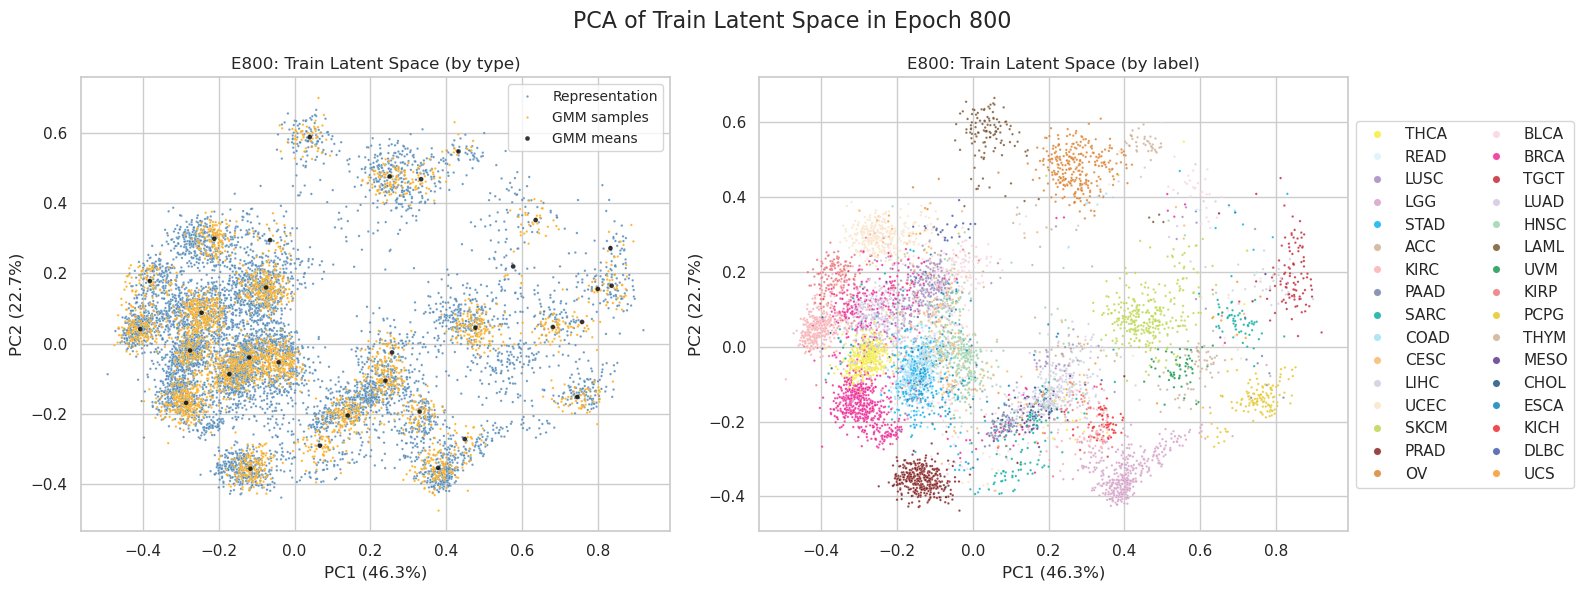

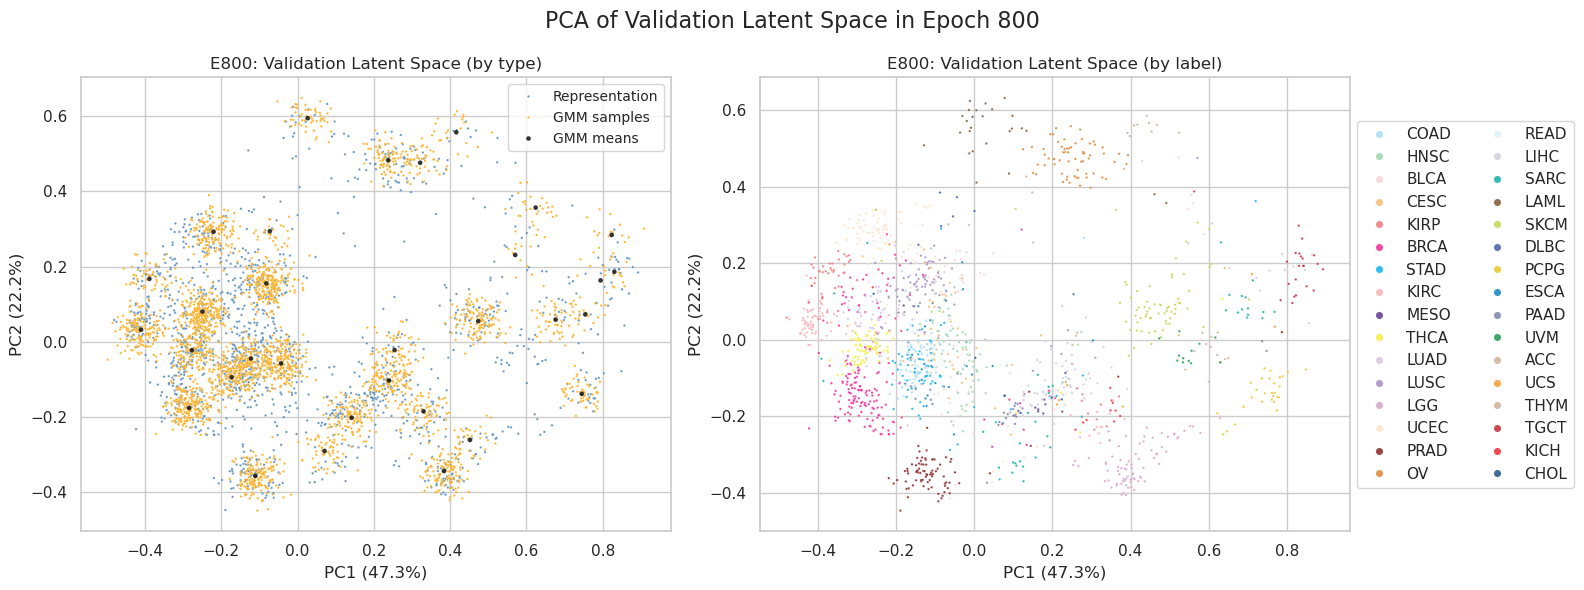

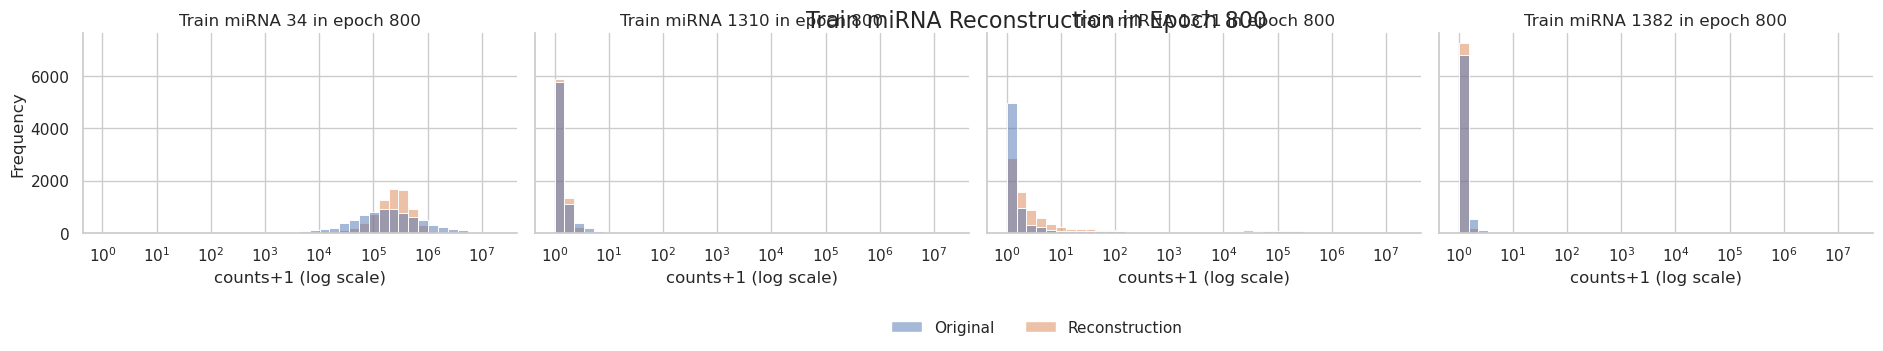

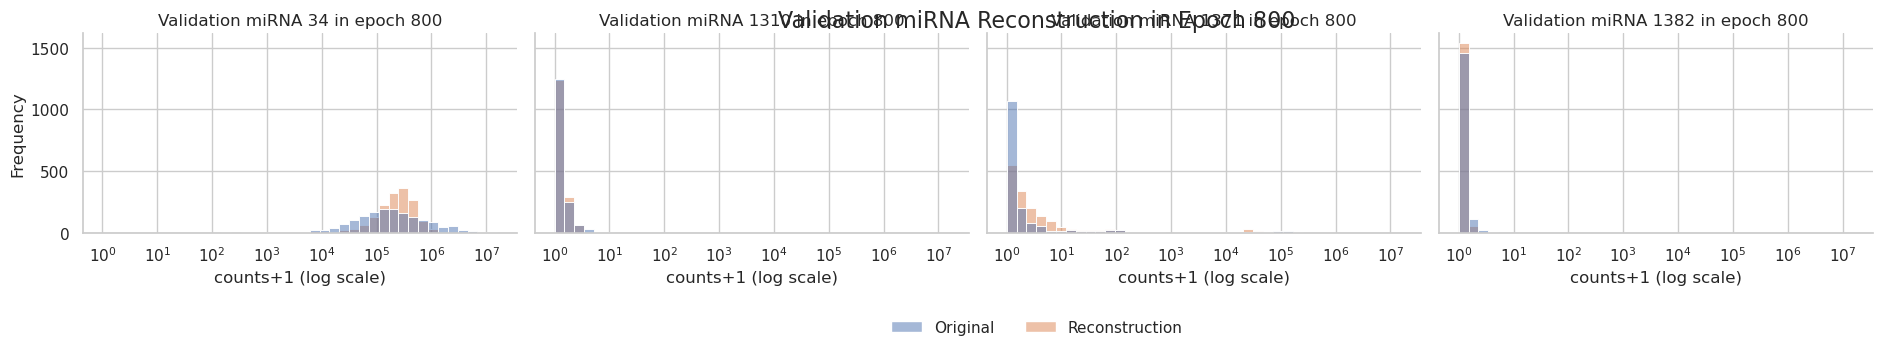

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 801/801 [19:09<00:00,  1.43s/it]


In [19]:
loss_tab = train_dgd_mirna(
        dgd, train_loader, validation_loader, device, train_dataset, validation_dataset,
        learning_rates=learning_rates, weight_decay=weight_decay, betas=betas, 
        nepochs=nepochs, pr=pr, plot=plot, reduction_type=reduction_type,
        sample_index=sample_index, subset = subset, wandb_log=False
    )

# Save Model

In [21]:
save_model = True

# Set results paths
if save_model:
    loss_path = 'results/final_loss_mirna.pickle'
    dgd_path = 'results/final_dgd_mirna.pickle'
    
    torch.save(loss_tab, loss_path)
    torch.save(dgd, dgd_path)

# Plotting

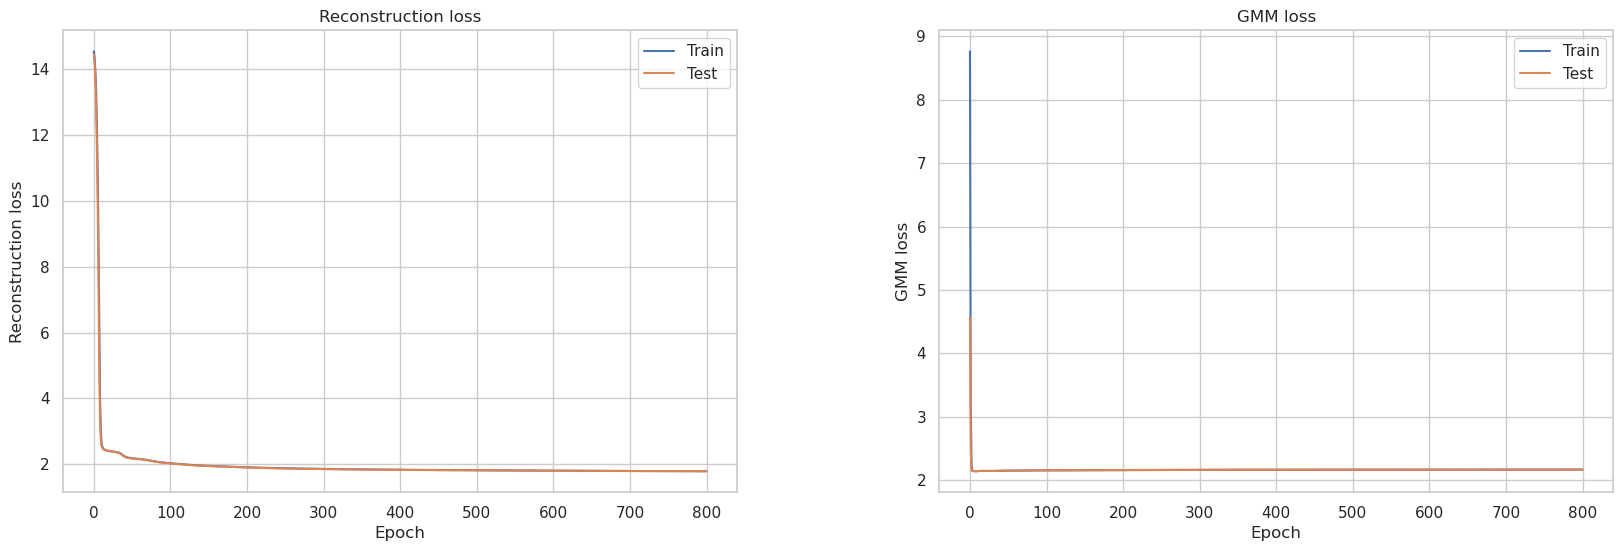

In [20]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create a figure to hold the subplots
plt.figure(figsize=(20, 6))
plt.subplots_adjust(wspace=0.3)

# First subplot for Reconstruction loss
plt.subplot(1, 2, 1)
sns.lineplot(x="epoch", y="train_recon", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_recon", data=loss_tab, label="Test")
plt.title("Reconstruction loss")
plt.xlabel("Epoch")
plt.ylabel("Reconstruction loss")

# Second subplot for GMM loss
plt.subplot(1, 2, 2)
sns.lineplot(x="epoch", y="train_gmm", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_gmm", data=loss_tab, label="Test")
plt.title("GMM loss")
plt.xlabel("Epoch")
plt.ylabel("GMM loss")

# Display the plots
plt.show()

# Load Model

In [15]:
dgd = torch.load('results/final_dgd_mirna.pickle', map_location=torch.device('cpu'))
# dgd = torch.load('results/final_dgd_mirna.pickle')

In [16]:
def prepare_potential_reps(sample_list):
    return sample_list[0]

def learn_new_representation(dgd, 
                             data_loader,
                             test_epochs=50,
                             learning_rates=1e-2, 
                             weight_decay=0.,
                             betas=(0.5, 0.7),
                             reduction_type="sum",
                             resampling_type="mean"):
    """
    This function learns a new representation layer for the DGD.
    The new representation layer is learned by sampling new points
    from the GMMs and finding the best fitting GMM for each sample.
    The new representation layer is then optimized to minimize the
    reconstruction loss of the DGD.
    """
    
    gmm_loss = True
    n_samples_new = len(data_loader.dataset)
    potential_reps = prepare_potential_reps([dgd.gmm.sample_new_points(resampling_type)])

    dgd.eval()
    X_data = dgd.decoder(potential_reps.to(device))

    rep_init_values = torch.zeros((n_samples_new, potential_reps.shape[-1]))

    for (data, lib, i) in tqdm(data_loader.dataset):
        loss = torch.empty(0).to(device)
        for X in X_data:
            recon_loss = dgd.decoder.loss(
                nn_output=X.to(device), 
                target=data.to(device), 
                scale=lib, 
                mod_id="single", 
                feature_ids=None, 
                reduction="sum", 
                type="mrna"
            )
            loss = torch.cat((loss, recon_loss.unsqueeze(0)))
        best_fit_ids = torch.argmin(loss, dim=-1).detach().cpu()
        rep_init_values[i, :] = potential_reps.clone()[best_fit_ids, :]

    Ntest=len(data_loader.dataset)
    new_rep = RepresentationLayer(n_rep=dgd.rep_dim, 
                                  n_sample=Ntest,
                                  value_init=rep_init_values).to(device)
    test_rep_optimizer = torch.optim.AdamW(new_rep.parameters(), lr=learning_rates, weight_decay=weight_decay, betas=betas)

    for epoch in tqdm(range(test_epochs)):
        test_rep_optimizer.zero_grad()
        for (data, lib, index) in data_loader:
            recon_loss, gmm_loss = dgd.forward_and_loss(
                z=new_rep(index),
                target=data.to(device),
                scale=lib.unsqueeze(1).to(device), 
                gmm_loss=gmm_loss,
                reduction=reduction_type,
                type="mrna"
            )
            loss = recon_loss + gmm_loss
            loss.backward()
        test_rep_optimizer.step()
    
    return new_rep 

In [17]:
new_rep = learn_new_representation(dgd, test_loader, learning_rates=1e-2, weight_decay=0., test_epochs=50)
dgd.test_rep = new_rep

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:08<00:00,  1.37s/it]


In [18]:
dgd

DGD(
  (decoder): Decoder(
    (main): ModuleList(
      (0): Linear(in_features=20, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): ReLU()
    )
    (out_module): NB_Module(
      (fc): Sequential(
        (0): Linear(in_features=128, out_features=2024, bias=True)
      )
    )
  )
  (gmm): GaussianMixture()
  (train_rep): RepresentationLayer()
  (val_rep): RepresentationLayer()
  (test_rep): RepresentationLayer()
)

# Simple Analysis

In [33]:
from base.plotting.plot_cv2 import plot_latent_space, plot_mirna

## Test Set

In [19]:
from sklearn.decomposition import PCA

def plot_latent_space(rep, means, samples, gmm, labels, color_mapping, dataset="Train", 
                      savedir="plots", filename=None):
    # get PCA
    pca = PCA(n_components=2)
    pca.fit(rep)
    rep_pca = pca.transform(rep)
    means_pca = pca.transform(means)
    samples_pca = pca.transform(samples)
    df = pd.DataFrame(rep_pca, columns=["PC1", "PC2"])
    df["type"] = "Representation"
    df["label"] = labels
    df_temp = pd.DataFrame(samples_pca, columns=["PC1", "PC2"])
    df_temp["type"] = "GMM samples"
    df = pd.concat([df,df_temp])
    df_temp = pd.DataFrame(means_pca, columns=["PC1", "PC2"])
    df_temp["type"] = "GMM means"
    df = pd.concat([df,df_temp])

    # make a figure with 2 subplots
    # set a small text size for figures
    plt.rcParams.update({'font.size': 6})
    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    # add spacing between subplots
    fig.subplots_adjust(wspace=0.2, top=0.9)

    # first plot: representations, means and samples
    sns.scatterplot(data=df, x="PC1", y="PC2", hue="type", size="type", sizes=[5,3,12], alpha=0.8, ax=ax[0], palette=["steelblue","orange","black"])
    ax[0].set_title(str(dataset)+" Latent Space (by type)")
    ax[0].legend(loc='upper right', fontsize='small')
    
    # add explained variance to x-label and y-label for first plot
    ax[0].set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
    ax[0].set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")

    # second plot: representations by label
    sns.scatterplot(data=df[df["type"] == "Representation"], x="PC1", y="PC2", hue="label", s=6, alpha=0.8, ax=ax[1], palette=color_mapping)
    ax[1].set_title(str(dataset)+" Latent Space (by label)")
    ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2, markerscale=3)
    
    # add explained variance to x-label and y-label for second plot
    ax[1].set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
    ax[1].set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")


    # plot
    plt.suptitle(f'PCA of {dataset} Latent Space', fontsize=16)
    plt.tight_layout()
    
    if filename:
        plt.savefig(os.path.join(savedir, filename))
    plt.show()

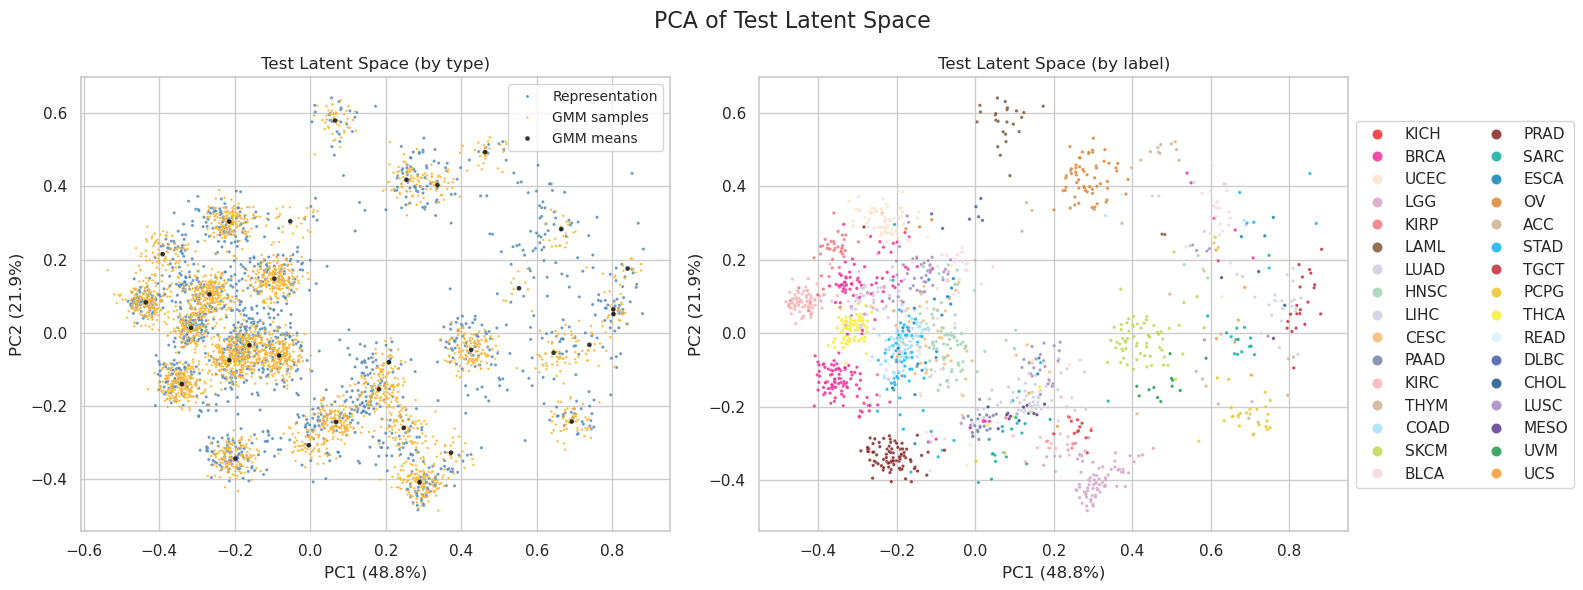

In [20]:
plot_latent_space(*dgd.get_latent_space_values("test",3000), dgd.gmm, test_loader.dataset.label, color_mapping, dataset="Test",
                 filename="PCA of miRNA test latent space.pdf")

In [21]:
# Change column name
mirna_column = pd.Series(train_mirna.columns[:-4])

# Convert mirna_annot DataFrame to a dictionary for mapping
mapping_dict = dict(zip(mirna_annot['mature_iso_id'], mirna_annot['mature_iso_name_miRBase']))

# Replace the values in mirna_column using the mapping dictionary
mirna_column = mirna_column.map(mapping_dict).fillna(mirna_column)
mirna_column = np.array(mirna_column)

def _add_columns(X, y, data_loader):
    X = X.assign(tissue=data_loader.dataset.tissue_type)
    X = X.assign(sample=data_loader.dataset.sample_type)
    X = X.assign(color=data_loader.dataset.color)
    X = X.assign(cancer_type=data_loader.dataset.label)
    
    y = y.assign(tissue=data_loader.dataset.tissue_type)
    y = y.assign(sample=data_loader.dataset.sample_type)
    y = y.assign(color=data_loader.dataset.color)
    y = y.assign(cancer_type=data_loader.dataset.label)
    return X, y

def _get_data_prediction(dgd, data_loader, mirna_column_name, dataset="train"):
    with torch.inference_mode():
        scaling = torch.mean(data_loader.dataset.data, axis=1)
        if dataset == "train":
            X = dgd.forward(dgd.train_rep()) 
        elif dataset == "val":
            X = dgd.forward(dgd.val_rep()) 
        elif dataset == "test":
            X = dgd.forward(dgd.test_rep()) 
        X = X * scaling.unsqueeze(1).to(device)
        X = X.detach().cpu().numpy()
        X = pd.DataFrame(X, columns=mirna_column_name)

        y = data_loader.dataset.data
        y = y.detach().cpu().numpy()
        y = pd.DataFrame(y, columns=mirna_column_name)
        
        X, y = _add_columns(X, y, data_loader)
    return X, y

def _get_data_pred_from_rep(dgd, test_rep, data_loader, mirna_column_name):
    with torch.inference_mode():
        scaling = torch.mean(data_loader.dataset.data, axis=1)
        X = dgd.forward(test_rep.z) 
        X = X * scaling.unsqueeze(1).to(device)
        X = X.detach().cpu().numpy()
        X = pd.DataFrame(X, columns=mirna_column_name)

        y = data_loader.dataset.data
        y = y.detach().cpu().numpy()
        y = pd.DataFrame(y, columns=mirna_column_name)
        
        X, y = _add_columns(X, y, data_loader)
    return X, y
    
def generate_analysis_data(dgd, train_loader, validation_loader, test_loader, mirna_column_name, subset=False, dataset="test"):
    if subset:
        if dataset == "train":
            X_train, y_train = _get_data_prediction(dgd, train_loader, mirna_column_name, dataset="train")
            train = pd.DataFrame(
                data={
                    'X': X_train[subset], 
                    'y': y_train[subset],
                    'cancer_type': train_loader.dataset.label,
                    'tissue': train_loader.dataset.tissue_type,
                    'color': train_loader.dataset.color
                }
            )
            return train
        elif dataset == "val":
            X_val, y_val = _get_data_prediction(dgd, validation_loader, mirna_column_name, dataset="val")
            val = pd.DataFrame(
                data={
                    'X': X_val[subset], 
                    'y': y_val[subset],
                    'cancer_type': validation_loader.dataset.label,
                    'tissue': validation_loader.dataset.tissue_type,
                    'color': validation_loader.dataset.color
                }
            )
            return val
        elif dataset == "test":
            X_test, y_test = _get_data_prediction(dgd, test_loader, mirna_column_name, dataset="test")
            test = pd.DataFrame(
                data={
                    'X': X_test[subset], 
                    'y': y_test[subset],
                    'cancer_type': test_loader.dataset.label,
                    'tissue': test_loader.dataset.tissue_type,
                    'color': test_loader.dataset.color
                }
            )
            return test
    else:
        X_train, y_train = _get_data_prediction(dgd, train_loader, mirna_column_name, dataset="train")
        X_val, y_val = _get_data_prediction(dgd, validation_loader, mirna_column_name, dataset="val")
        X_test, y_test = _get_data_prediction(dgd, test_loader, mirna_column_name, dataset="test")
        
    return X_train, y_train, X_val, y_val, X_test, y_test

def get_mirna_data(dgd, data_loader, subset, mirna_column_name=mirna_column, dataset="test"):
    return generate_analysis_data(dgd, *data_loader, mirna_column_name, subset=subset, dataset=dataset)

X_train, y_train, X_val, y_val, X_test, y_test = generate_analysis_data(dgd, train_loader, validation_loader, test_loader, mirna_column)

In [23]:
from scipy import stats

def calculate_corr(X, y, axis=0):
    spearman_corr = []
    pearson_corr = []
    spearman_pval = []
    pearson_pval = []
    r2 = []
    r2_pval = []
    X = X.iloc[:,:-4]
    y = y.iloc[:,:-4]
    
    if axis == 0:
        for i in range(y.shape[1]):
            # Calculate Spearman correlation coefficient
            spearman, spearman_p = stats.spearmanr(X.iloc[:, i], y.iloc[:, i])
            pearson, pearson_p = stats.pearsonr(X.iloc[:, i], y.iloc[:, i])
            _, _, r_value, r_p, _ = stats.linregress(X.iloc[:, i], y.iloc[:, i])
            
            spearman_corr.append(spearman)
            pearson_corr.append(pearson)
            r2.append(r_value**2)
            spearman_pval.append(spearman_p)
            pearson_pval.append(pearson_p)
            r2_pval.append(r_p)
        
        corr_data = pd.DataFrame(
            data={  
                'pearson': pearson_corr,
                'spearman': spearman_corr,
                'r2': r2,
                'pearson_p': pearson_pval,
                'spearman_p': spearman_pval,
                'r2_p': r2_pval,
                'mirna': X.columns
            },
            index=np.arange(0, len(X.columns))
        )
    elif axis == 1:
        for i in range(y.shape[0]):
            # Calculate Spearman correlation coefficient
            spearman, spearman_p = stats.spearmanr(X.iloc[i, :], y.iloc[i, :])
            pearson, pearson_p = stats.pearsonr(X.iloc[i, :], y.iloc[i, :])
            _, _, r_value, r_p, _ = stats.linregress(X.iloc[i, :], y.iloc[i, :])
            
            spearman_corr.append(spearman)
            pearson_corr.append(pearson)
            r2.append(r_value**2)
            spearman_pval.append(spearman_p)
            pearson_pval.append(pearson_p)
            r2_pval.append(r_p)
        
        corr_data = pd.DataFrame(
            data={  
                'pearson': pearson_corr,
                'spearman': spearman_corr,
                'r2': r2,
                'pearson_p': pearson_pval,
                'spearman_p': spearman_pval,
                'r2_p': r2_pval,
                'mirna': X.index[:-4]
            },
            index=np.arange(0, len(X.index))
        )
    else:
        raise ValueError("Axis must be 0 (columns) or 1 (rows).")
    
    return corr_data.sort_values(by='pearson', ascending=False, ignore_index=True)

corr_data = calculate_corr(X_test, y_test, axis=1)

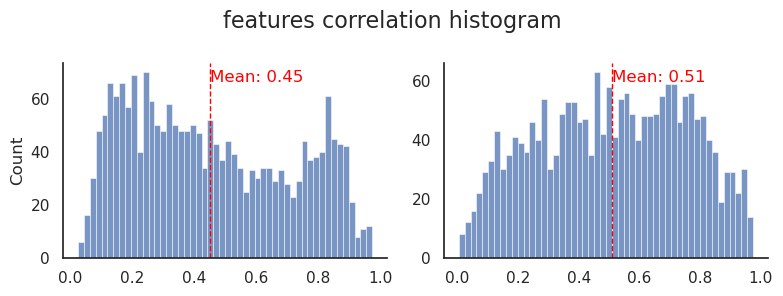

In [31]:
corr_data = calculate_corr(X_test, y_test, axis=0)

sns.set_theme(style="whitegrid")
sns.set_style("white")
fig = plt.figure(figsize=(8,3))

plt.subplot(1, 2, 1)
sns.histplot(data=corr_data, x='spearman', bins=50)
# plt.title("Spearman's Correlation")
plt.xlabel("Spearman's Correlation").set_visible(False)
mean_spearman = corr_data['spearman'].mean()
plt.axvline(mean_spearman, color='red', linestyle='dashed', linewidth=1)
plt.text(mean_spearman, plt.gca().get_ylim()[1] * 0.9, f'Mean: {mean_spearman:.2f}', color='red')

plt.subplot(1,2,2)
sns.histplot(data=corr_data, x='pearson', bins=50)
# plt.title("Pearson's Correlation")
plt.xlabel("Pearson's Correlation").set_visible(False)
plt.ylabel("")
mean_pearson = corr_data['pearson'].mean()
plt.axvline(mean_pearson, color='red', linestyle='dashed', linewidth=1)
plt.text(mean_pearson, plt.gca().get_ylim()[1] * 0.9, f'Mean: {mean_pearson:.2f}', color='red')

# Add the main title to the figure
fig.suptitle("features correlation histogram", fontsize=16)

# Display the plots
sns.despine()
plt.tight_layout()
plt.savefig(os.path.join("plots", "corr mirna features.svg"))
plt.show()

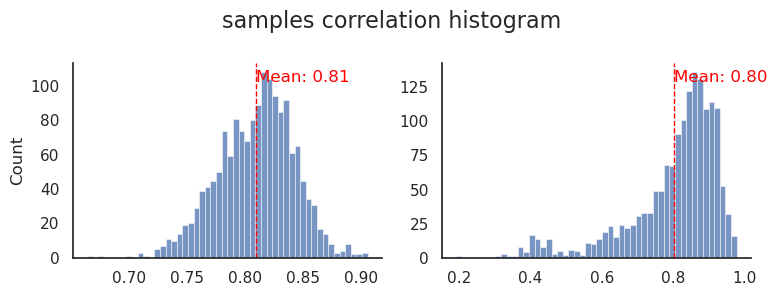

In [32]:
corr_data = calculate_corr(X_test, y_test, axis=1)

sns.set_theme(style="whitegrid")
sns.set_style("white")
fig = plt.figure(figsize=(8,3))

plt.subplot(1, 2, 1)
sns.histplot(data=corr_data, x='spearman', bins=50)
# plt.title("Spearman's Correlation")
plt.xlabel("Spearman's Correlation").set_visible(False)
mean_spearman = corr_data['spearman'].mean()
plt.axvline(mean_spearman, color='red', linestyle='dashed', linewidth=1)
plt.text(mean_spearman, plt.gca().get_ylim()[1] * 0.9, f'Mean: {mean_spearman:.2f}', color='red')

plt.subplot(1,2,2)
sns.histplot(data=corr_data, x='pearson', bins=50)
# plt.title("Pearson's Correlation")
plt.xlabel("Pearson's Correlation").set_visible(False)
plt.ylabel("")
mean_pearson = corr_data['pearson'].mean()
plt.axvline(mean_pearson, color='red', linestyle='dashed', linewidth=1)
plt.text(mean_pearson, plt.gca().get_ylim()[1] * 0.9, f'Mean: {mean_pearson:.2f}', color='red')

# Add the main title to the figure
fig.suptitle("samples correlation histogram", fontsize=16)

# Display the plots
sns.despine()
plt.tight_layout()
plt.savefig(os.path.join("plots", "corr mirna samples.svg"))
plt.show()

In [43]:
print((corr_data['spearman'] > 0.75).sum())
print((corr_data['pearson'] > 0.75).sum())

391
400


In [1]:
def regression_plot(subset, cancer_type=None, savedir="plots", filename=None):
    test = get_mirna_data(dgd, data_loader, subset=subset, dataset="test")

    if cancer_type:
        test = test[test['cancer_type'] == cancer_type]
    
    # Set the aesthetic style of the plots
    sns.set_style("whitegrid")
    
    # Create a figure to hold the subplots
    plt.figure(figsize=(5, 5))
    # plt.subplots_adjust(hspace=1)
    
    # Create scatterplot
    sns.regplot(data=test, x="X", y="y", scatter_kws={"s": 5, "alpha": .9}, line_kws={"color": "red", "alpha": .5})
    sns.despine()
    # Calculate Spearman correlation coefficient
    spearman_corr, spearman_p = stats.spearmanr(test['X'], test['y'])
    pearson_corr, pearson_p = stats.pearsonr(test['X'], test['y'])
    # Add correlation coefficient as text annotation
    plt.text(0.05, 0.95, f"Spearman's r = {spearman_corr:.2f}, p-value = <2.2e-16", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
    plt.text(0.05, 0.90, f"Pearson's r = {pearson_corr:.2f}, p-value = <2.2e-16", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
    plt.xlabel("Predicted expression", fontsize=12)
    plt.ylabel("True expression", fontsize=12)
    plt.xticks(fontsize=9)
    plt.yticks(fontsize=9)
    if cancer_type:
        plt.title(f"{subset} expression in {cancer_type} samples", fontsize=16, y=1.05)
    else:
        plt.title(f"{subset} expression", fontsize=16, y=1.05)
    plt.tight_layout()
    if filename:
        plt.savefig(os.path.join(savedir, filename), bbox_inches='tight')
    plt.show()

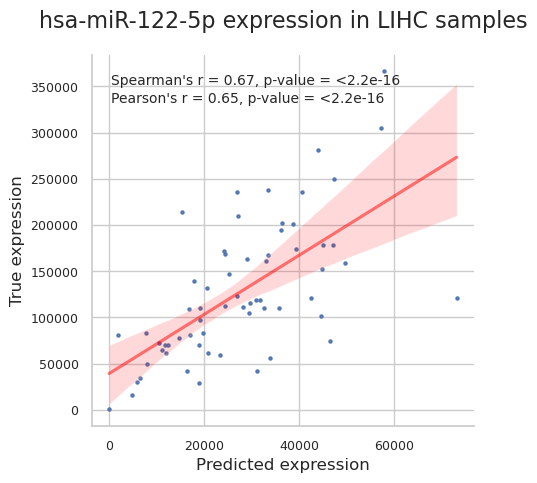

In [72]:
regression_plot('hsa-miR-122-5p', 'LIHC', filename="Regplot miRNA hsa-miR-122-5p.pdf")

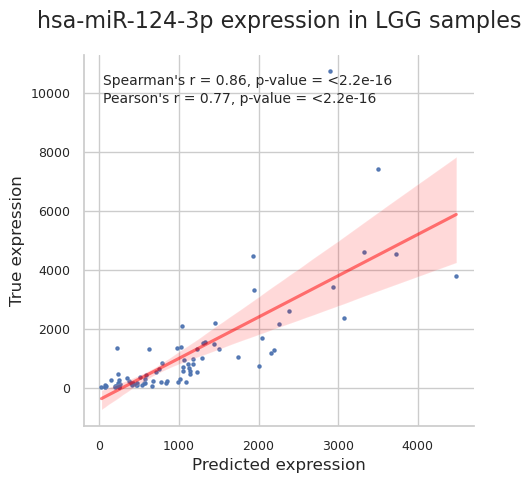

In [70]:
regression_plot('hsa-miR-124-3p', 'LGG', filename="Regplot miRNA hsa-miR-124-3p.pdf")

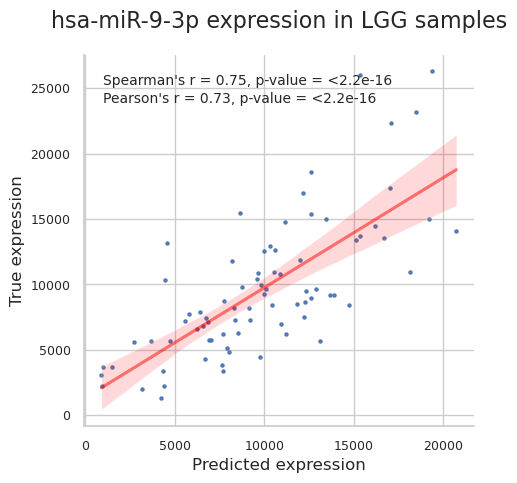

In [71]:
regression_plot('hsa-miR-9-3p', 'LGG', filename="Regplot miRNA hsa-miR-9-3p.pdf")

In [77]:
def plot_jitter_grouped_tissue(subset, figsize=(10, 5), savedir="plots", filename=None):
    data = get_mirna_data(dgd, data_loader, subset=subset)
    
    sns.set_style("whitegrid")
    plt.figure(figsize=figsize)
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    
    plt.subplot(2, 1, 1)
    sns.boxplot(data=data, x="cancer_type", y="y", hue="tissue", boxprops=dict(alpha=.3), showfliers=False)
    sns.stripplot(data=data, x="cancer_type", y="y", hue="tissue", alpha=0.8, zorder=0, palette="Paired")
    plt.title("")
    plt.xlabel("")
    plt.ylabel("True expression", fontsize=12)
    plt.xticks([], [])
    plt.yticks(fontsize=9)
    plt.legend(fontsize=8)
    
    plt.subplot(2, 1, 2)
    sns.boxplot(data=data, x="cancer_type", y="X", hue="tissue", boxprops=dict(alpha=.3), showfliers=False)
    sns.stripplot(data=data, x="cancer_type", y="X", hue="tissue", alpha=0.8, zorder=0, palette="Paired")
    plt.title("")
    plt.xlabel("Cancer Type", fontsize=14)
    plt.ylabel("Predicted expression", fontsize=12)
    plt.xticks(rotation=90, fontsize=12)
    plt.yticks(fontsize=9)
    plt.legend(fontsize=8).remove()

    for ax in plt.gcf().axes:
        labels = ax.get_xticklabels()
        for label, cancer_type in zip(labels, data['cancer_type'].unique()):
            label.set_color(palette[cancer_type])
    plt.suptitle(f"{subset} expression", fontsize=18)
    sns.despine(bottom=True)
    plt.tight_layout()
    if filename:
        plt.savefig(os.path.join(savedir, filename), bbox_inches='tight')
    plt.show()

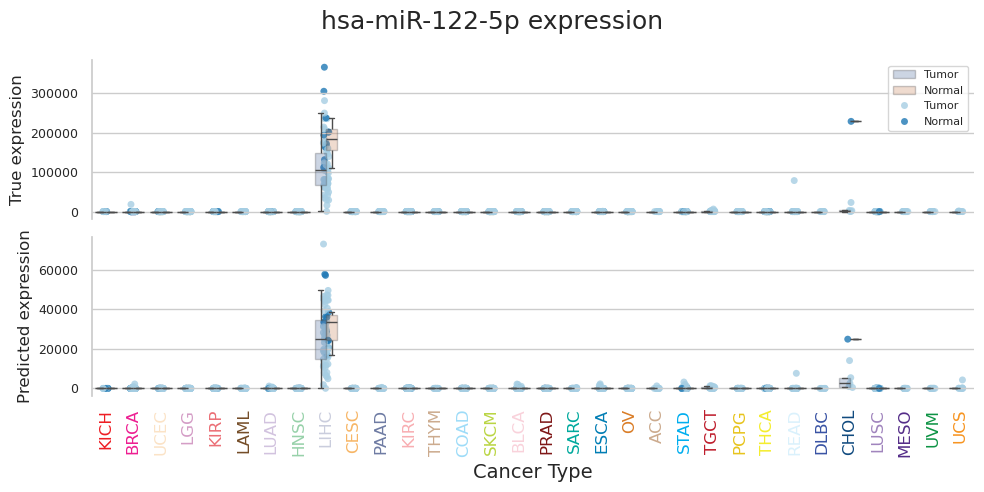

In [78]:
plot_jitter_grouped_tissue('hsa-miR-122-5p', filename="Group jitter miRNA hsa-miR-122-5p.pdf")

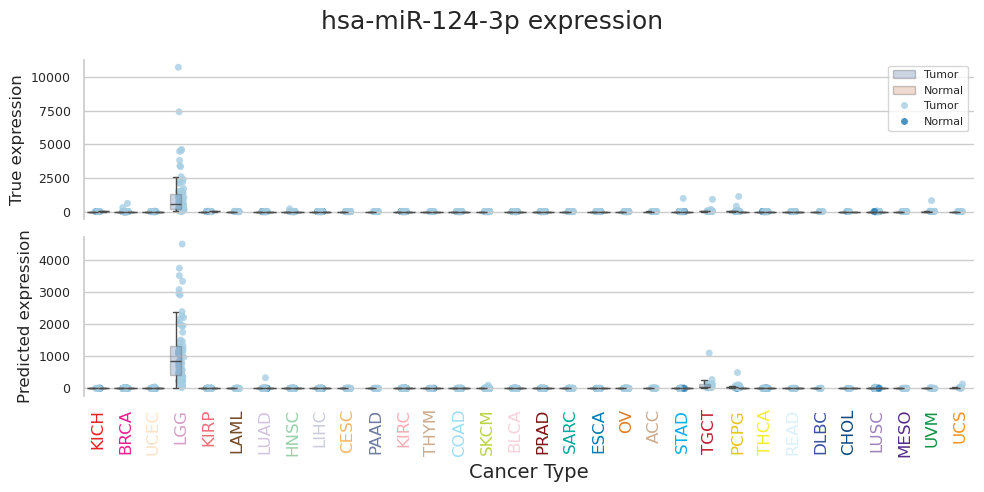

In [79]:
plot_jitter_grouped_tissue('hsa-miR-124-3p', filename="Group jitter miRNA hsa-miR-124-3p.pdf")

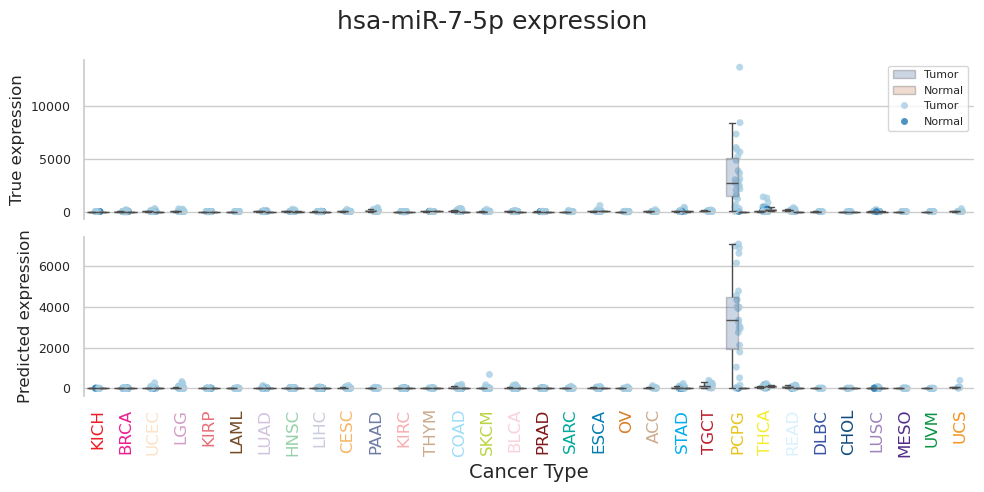

In [80]:
plot_jitter_grouped_tissue('hsa-miR-7-5p', filename="Group jitter miRNA hsa-miR-7-5p.pdf")

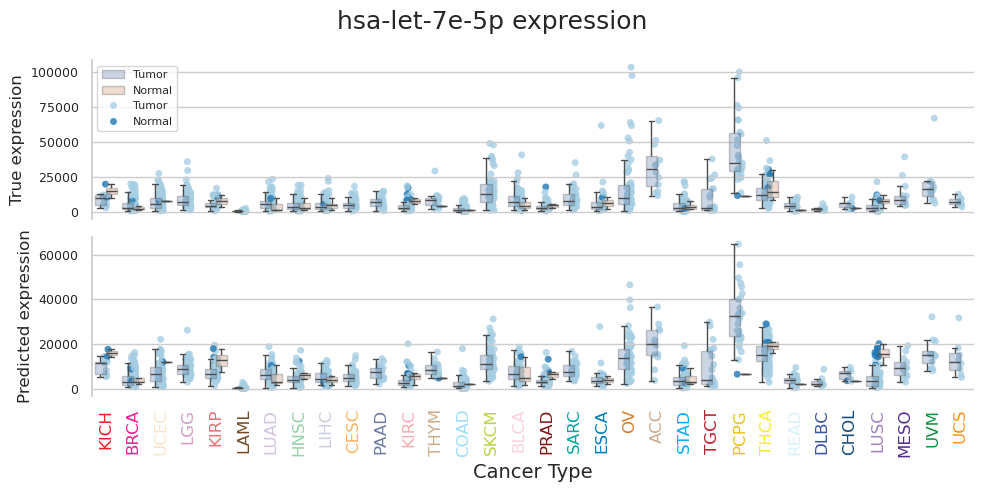

In [81]:
plot_jitter_grouped_tissue('hsa-let-7e-5p', filename="Group jitter miRNA hsa-let-7e-5p.pdf")

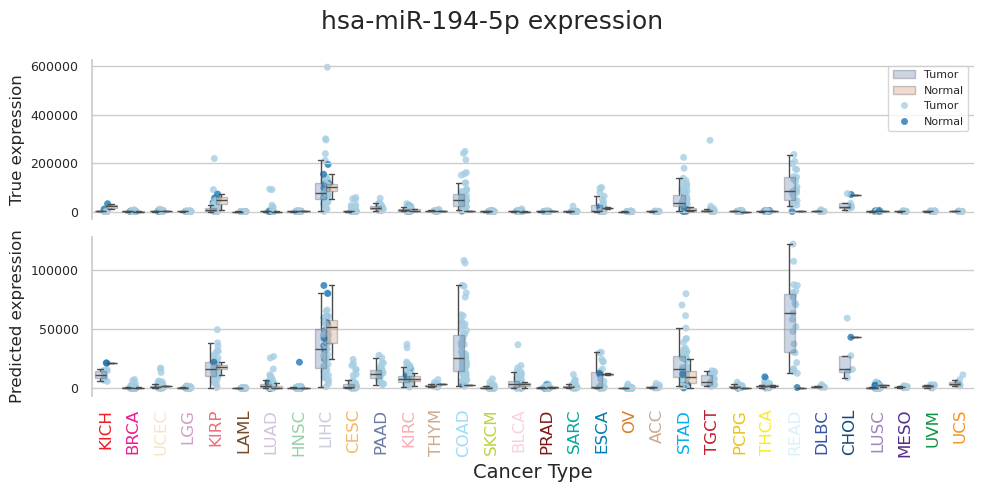

In [88]:
plot_jitter_grouped_tissue('hsa-miR-194-5p', filename="Group jitter miRNA hsa-miR-194-5p.pdf")